# Plotting 12/11/23

To do tomorrow, finish training other models and re-run all the plots below

In [1]:
from utils import (
    BaseForecaster, 
    ResidualForecaster,
    TimeSeriesPreprocessor,
    crps,
    HistoricalForecaster
)
from plotting_utils import (
    plot_forecast,
    plot_crps_bydate,
    score_improvement_bysite,
    #plot_improvement_bysite,
)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
from darts import TimeSeries
import numpy as np
import CRPS.CRPS as forecastscore
from darts.metrics import rmse
import matplotlib as mpl
from sklearn.cluster import KMeans

targets = pd.read_csv("targets.csv.gz")
metadata = pd.read_csv('NEON_Field_Site_Metadata_20220412.csv')
metadata = metadata.loc[metadata.aquatics == 1][['field_site_id', 'field_site_subtype', 'field_latitude', 'field_longitude']]

# Performing K-Means clustering
num_clusters = 5

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
metadata['cluster'] = kmeans.fit_predict(metadata[['field_latitude', 'field_longitude']])
region_mapping = {
    0: 'East',
    1: 'Alaska',
    2: 'West',
    3: 'Mid',
    4: 'Puerto Rico'
}
metadata['region'] = metadata['cluster'].map(region_mapping)

/home/rstudio/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Now let's get dataframes for all the models

In [2]:
model_names = ["RNN", "TFT", "BlockRNN", "Transformer",
               "NLinear", "DLinear", "NBEATS", "TCN"]
target_variables = ['oxygen', 'temperature', 'chla']
scores_dict = {}
for model in model_names:
    scores_dict[model] = {}
    for target_variable in target_variables:
        scores_dict[model][target_variable] = score_improvement_bysite(model, targets, target_variable, suffix='default')

Write something to save these because processing takes a while

In [3]:
for model in model_names:
    for target_variable in target_variables:
        scores_dict[model][target_variable].to_csv(f'scores/{model}_{target_variable}.csv', index=False)

And, to load.

In [4]:
scores_dict = {}
model_names = ["RNN", "TFT", "BlockRNN", "Transformer",
               "NLinear", "DLinear", "NBEATS", "TCN"]
target_variables = ['oxygen', 'temperature', 'chla']

for model in model_names:
    scores_dict[model] = {}
    for target_variable in target_variables:
        scores_dict[model][target_variable] = pd.read_csv(f'scores/{model}_{target_variable}.csv')

Plotting global model performance across the different target variables

In [25]:
global_dfs['temperature'].loc[global_dfs['temperature'].model == "BlockRNN"].combined_improvement.mean()

0.4398826979472141

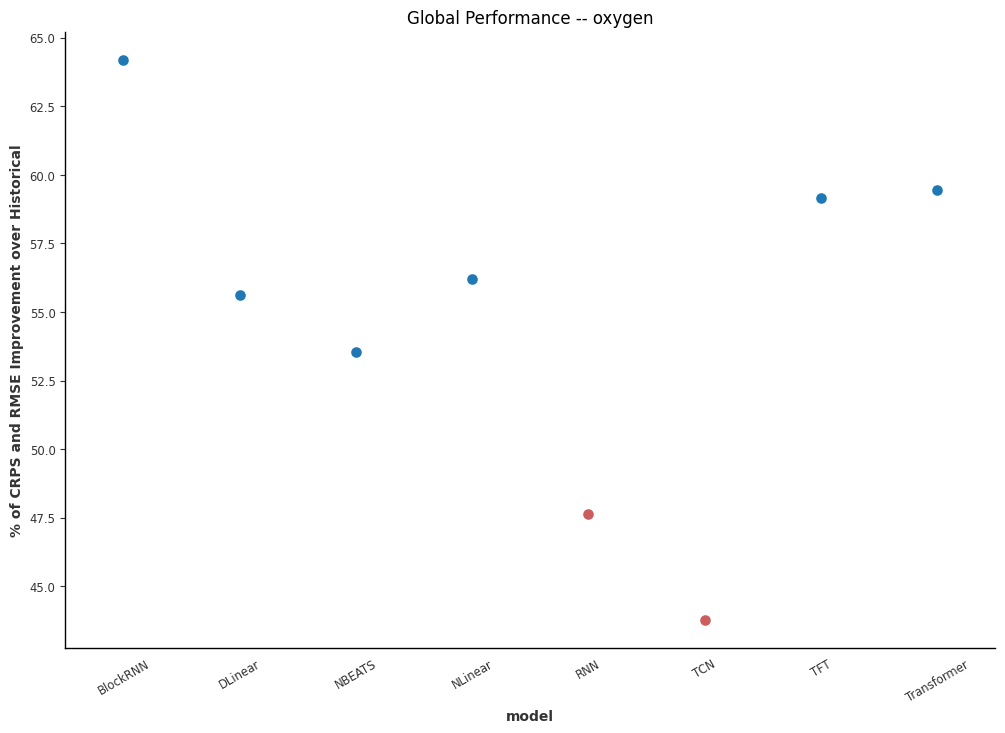

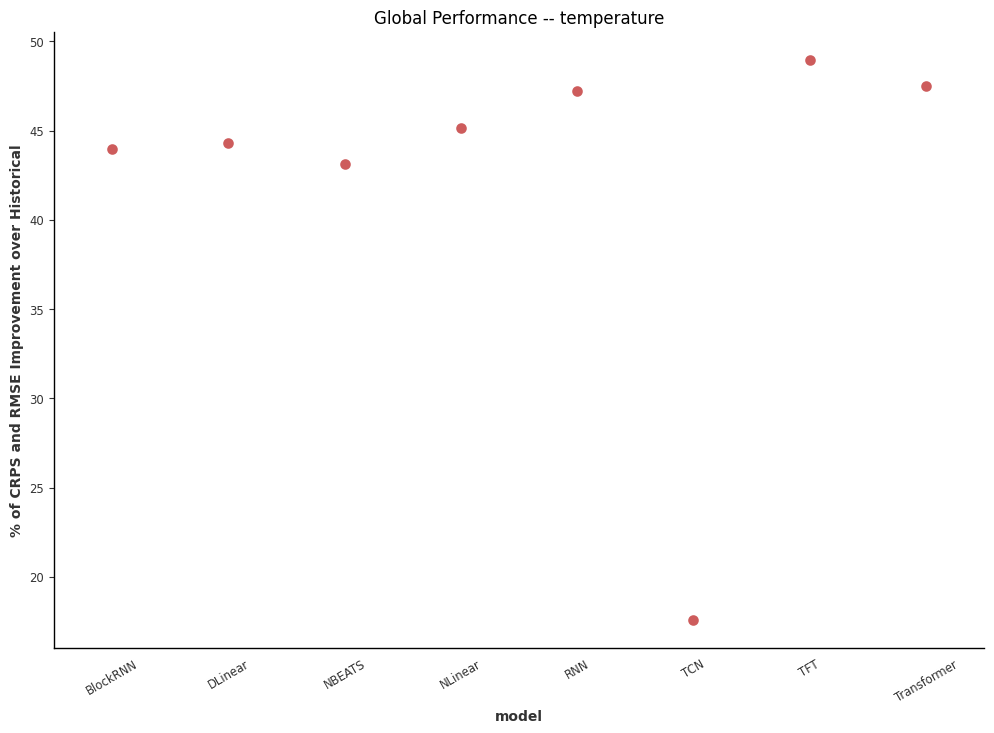

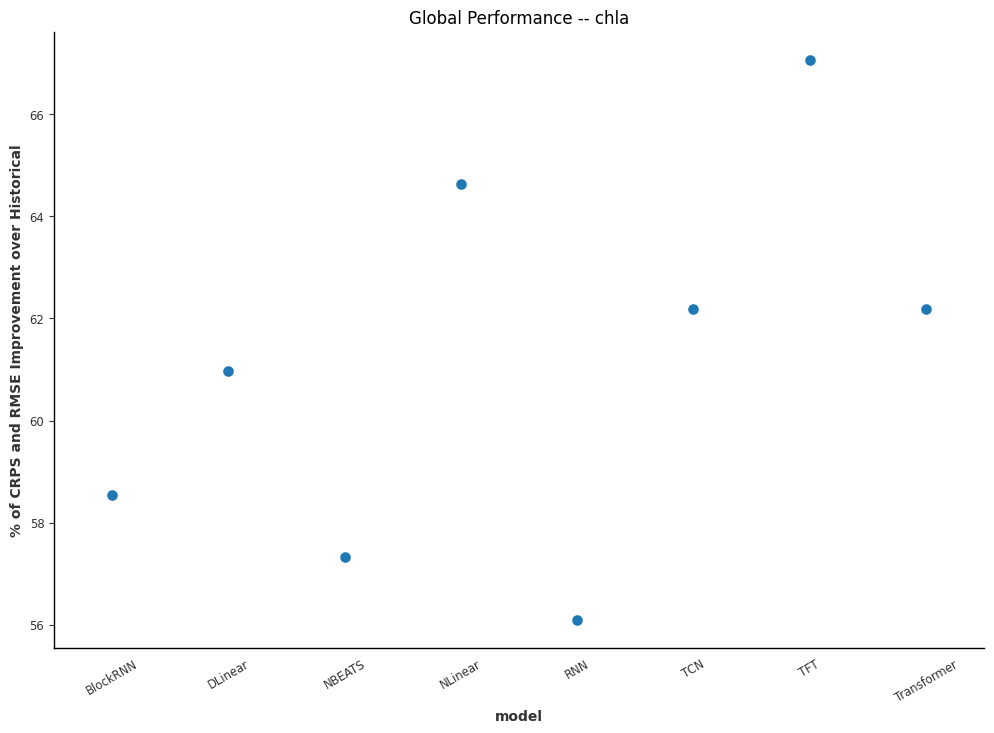

In [10]:
global_dfs = {}

for target_variable in target_variables:
    global_dfs[target_variable] = pd.concat([scores_dict[model][target_variable] for model in model_names])
    plot_global_percentages(global_dfs[target_variable], f'Global Performance -- {target_variable}')

Plot global performance by waterbody type

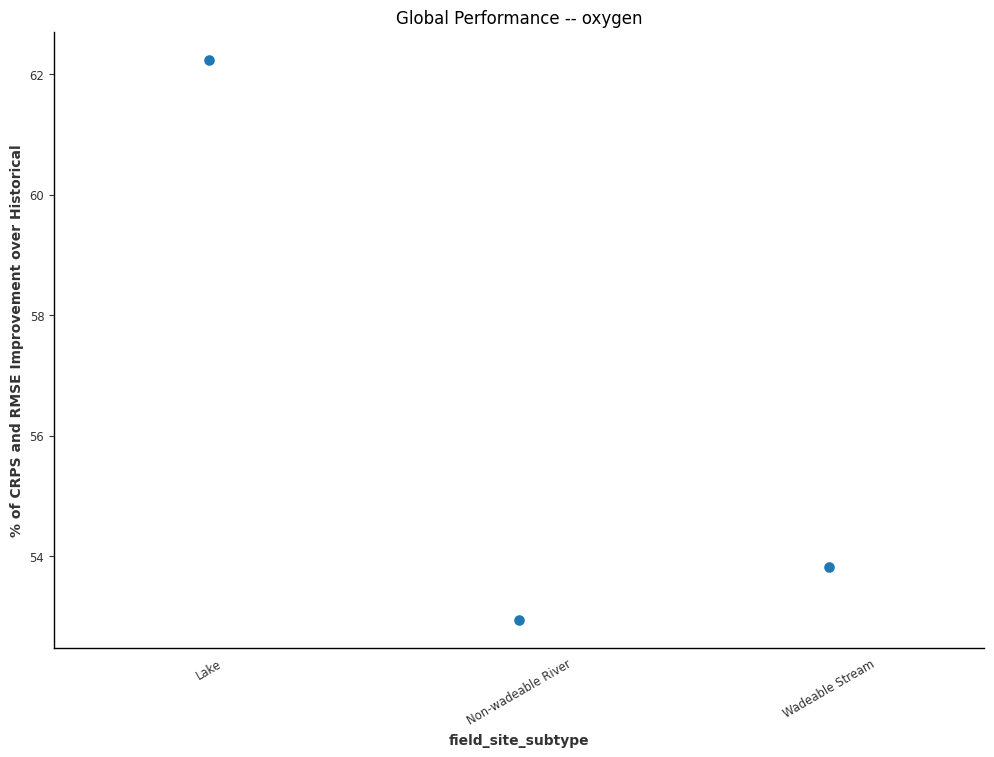

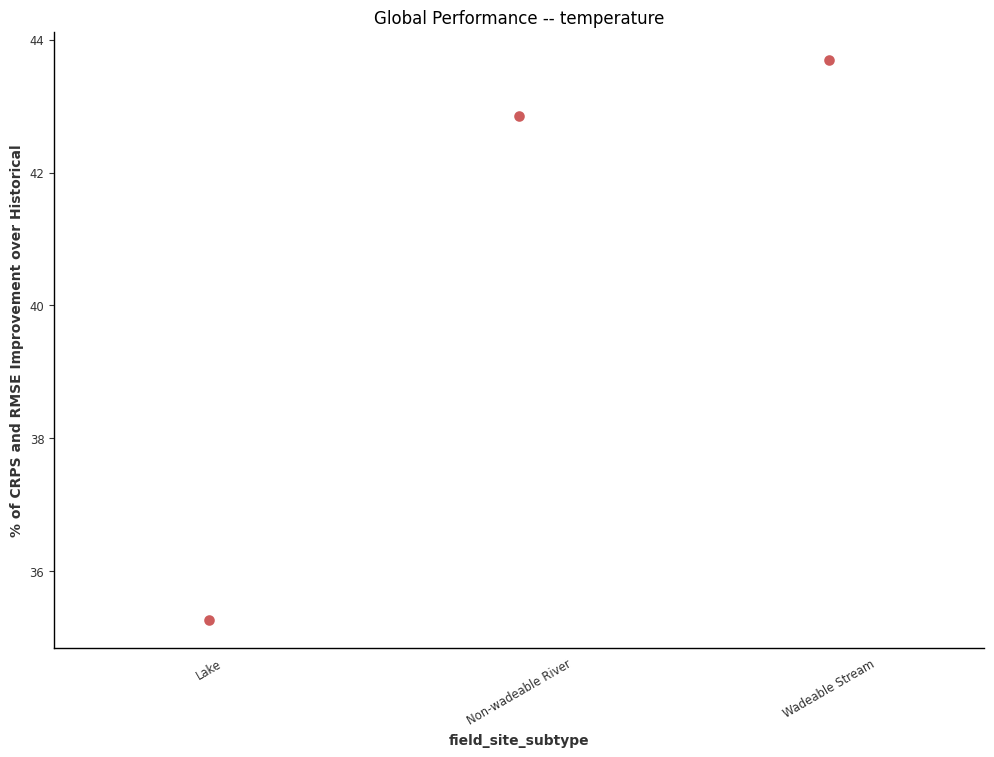

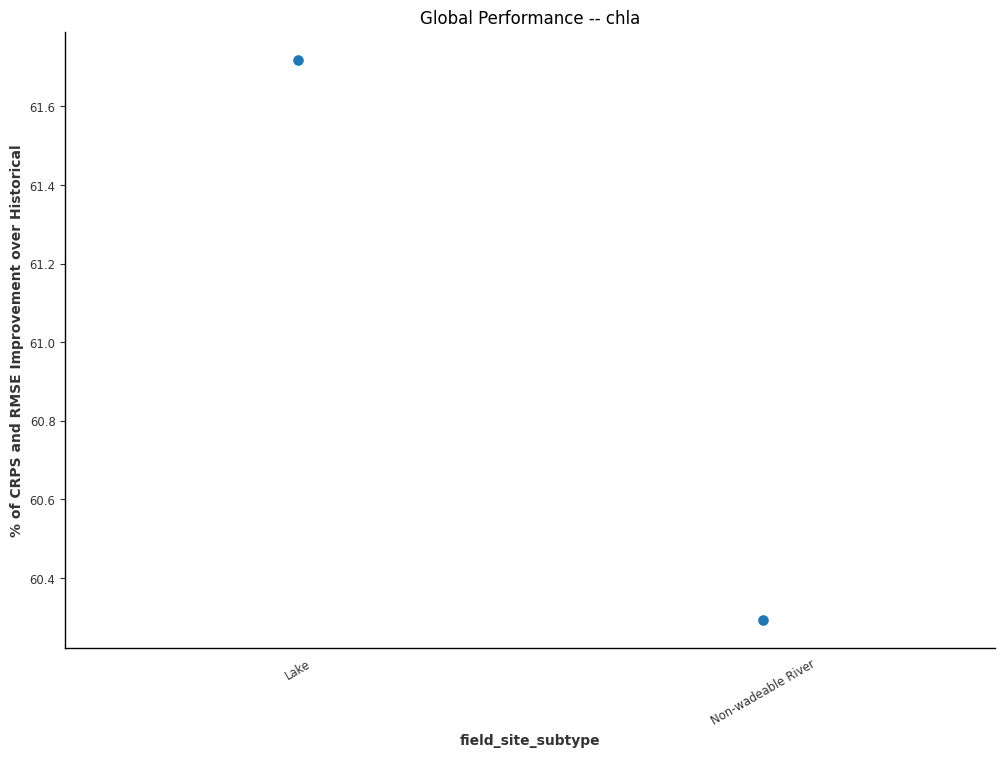

In [14]:
for target_variable in target_variables:
    plot_site_type_percentages_global(global_dfs[target_variable], metadata, f'Global Performance -- {target_variable}')

Plot performance by models on different water body types

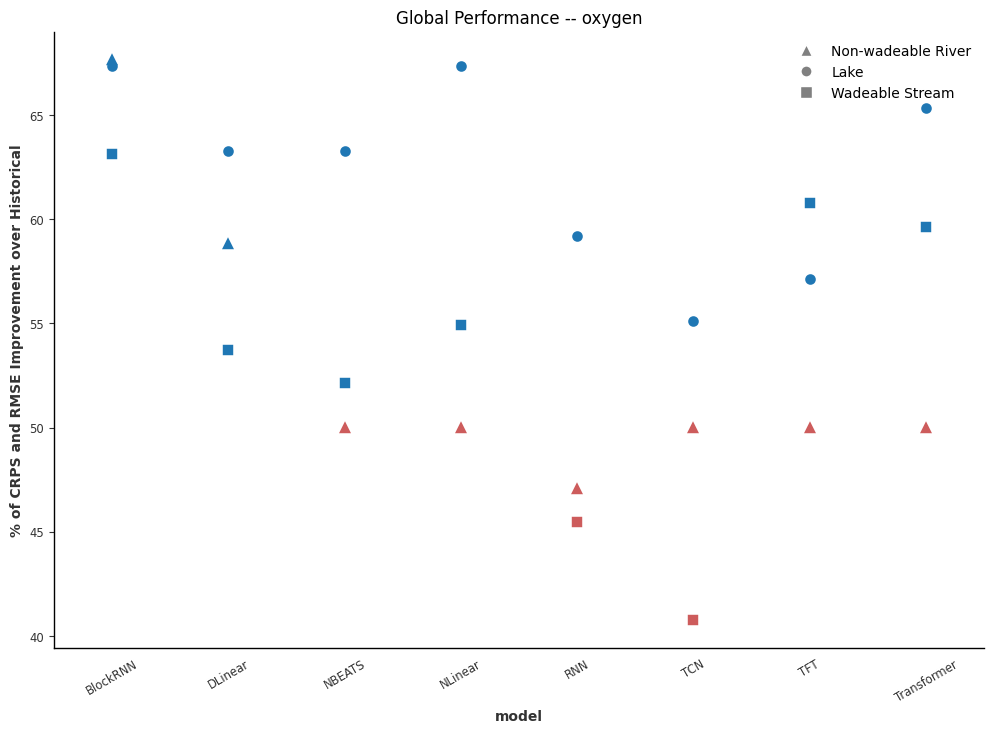

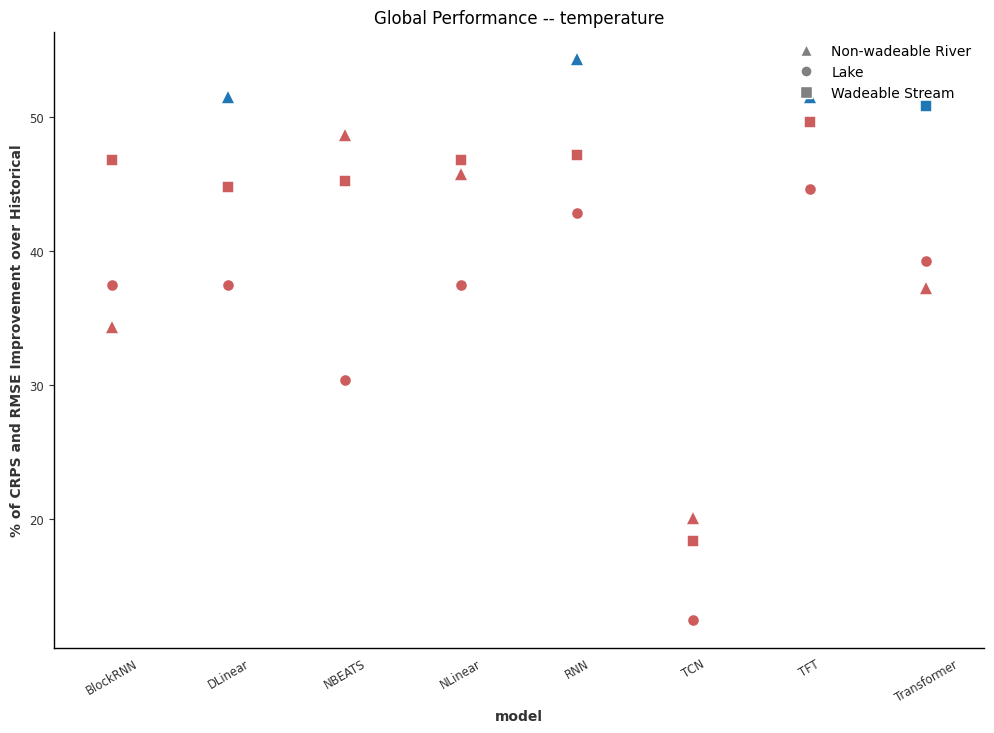

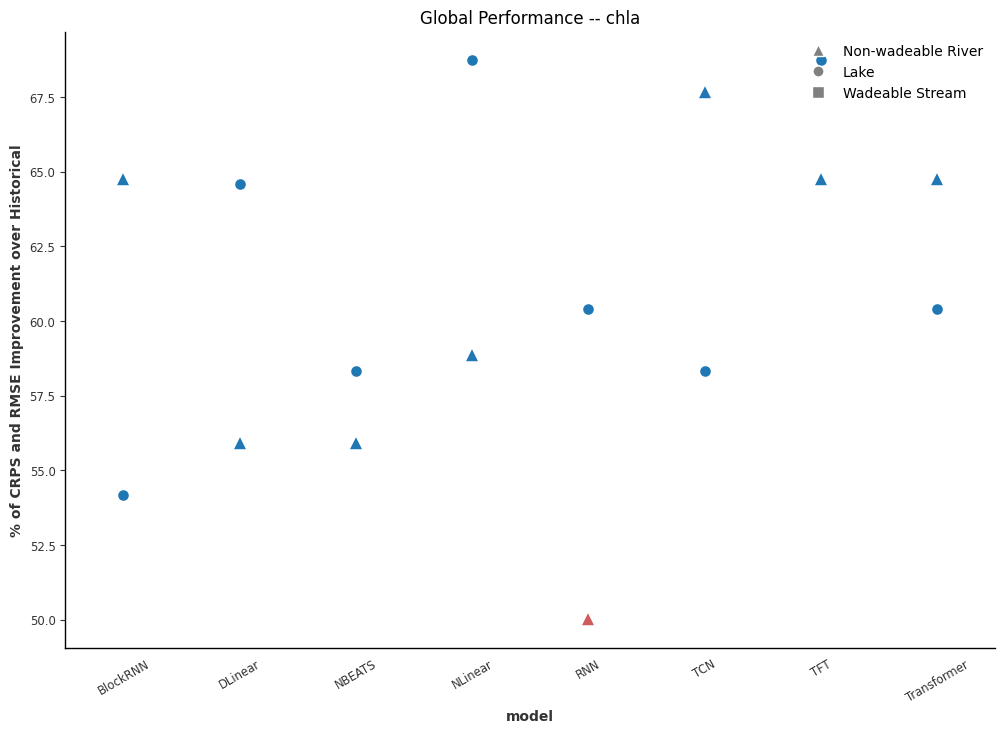

In [15]:
for target_variable in target_variables:
    plot_site_type_percentages_bymodel(global_dfs[target_variable], metadata, f'Global Performance -- {target_variable}')

Plot according to date

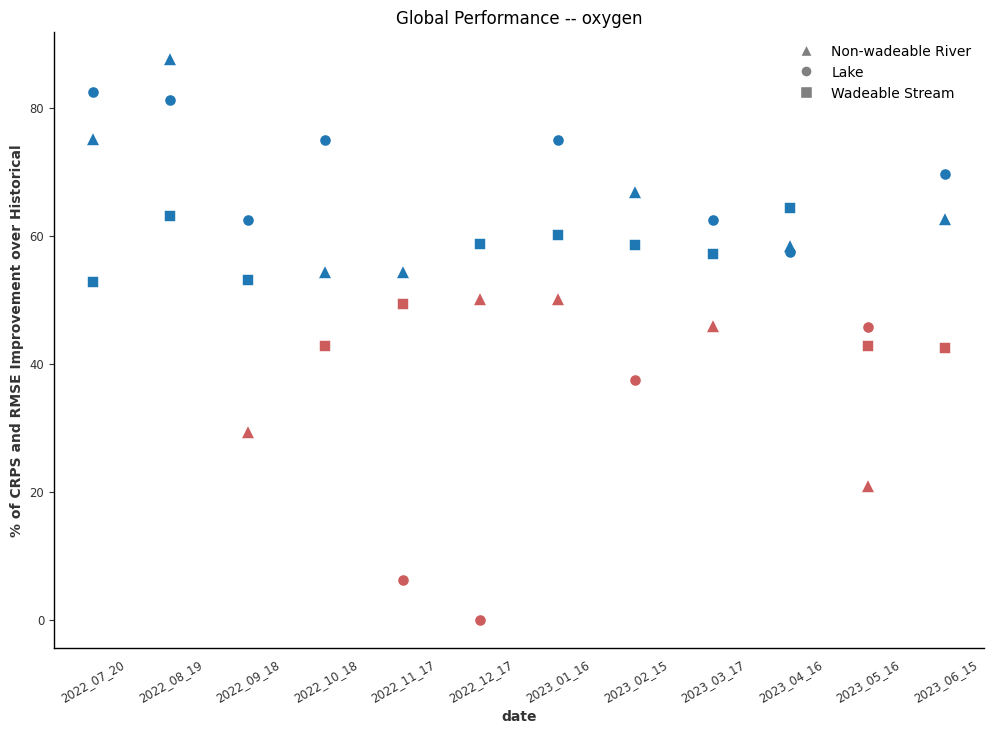

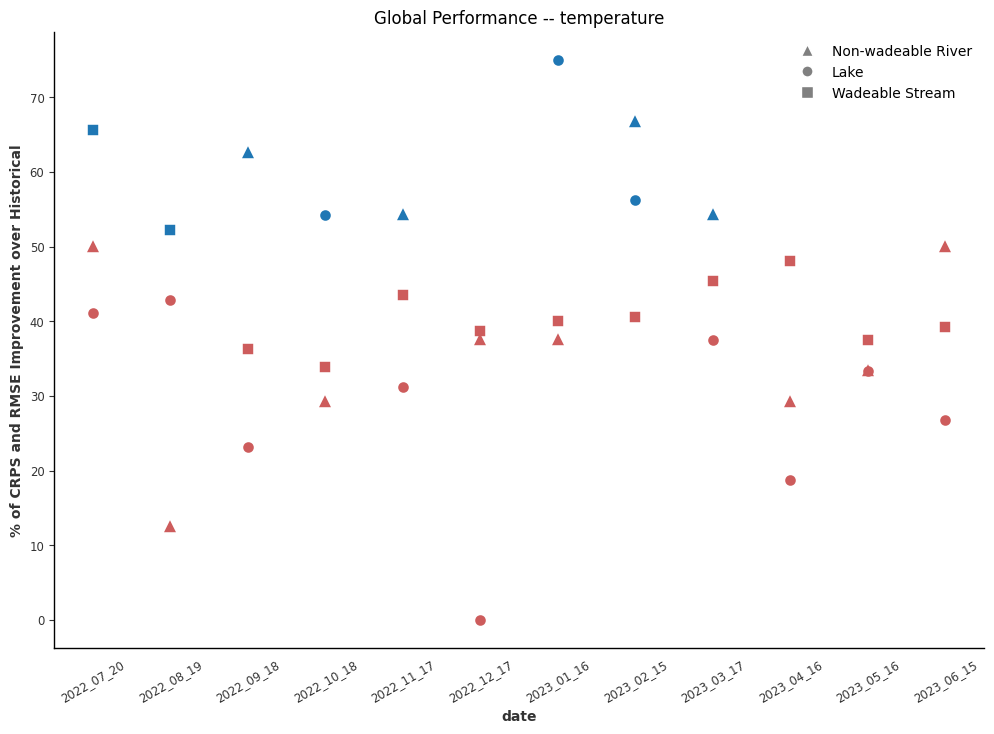

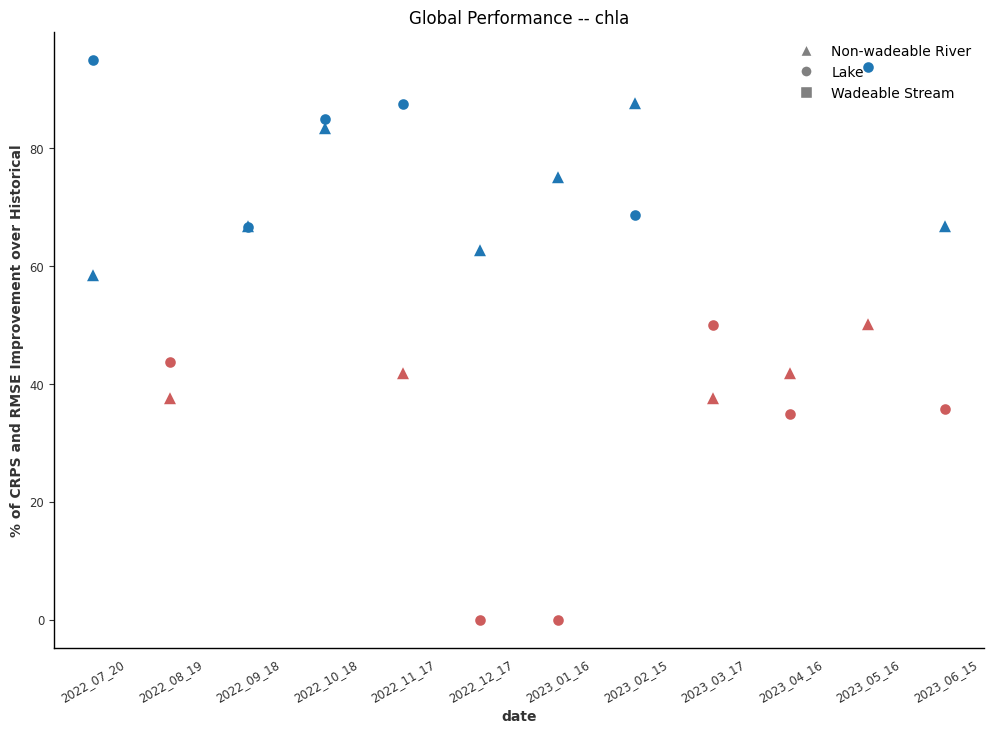

In [17]:
for target_variable in target_variables:
    plot_window_and_sitetype_performance(global_dfs[target_variable], metadata, f'Global Performance -- {target_variable}')

Then Geographical region

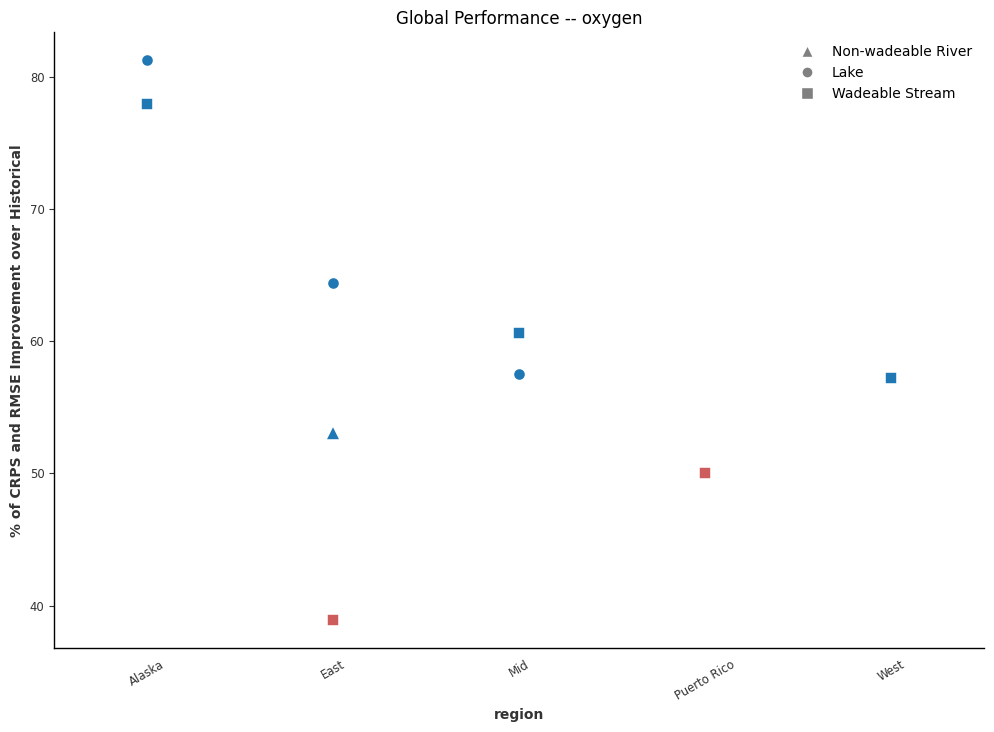

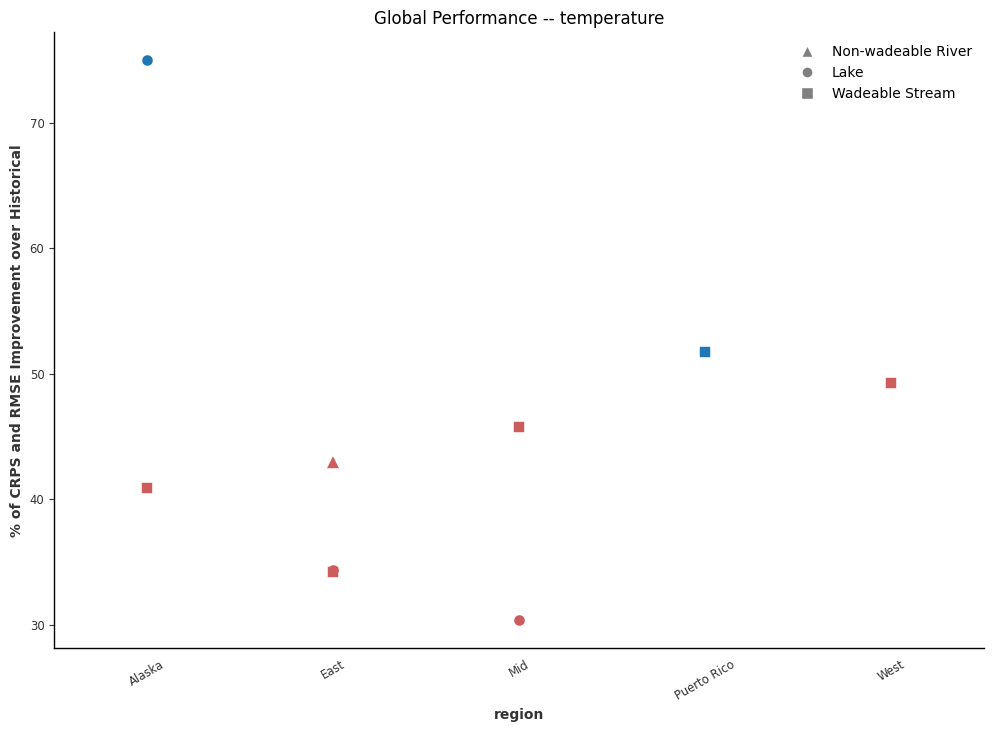

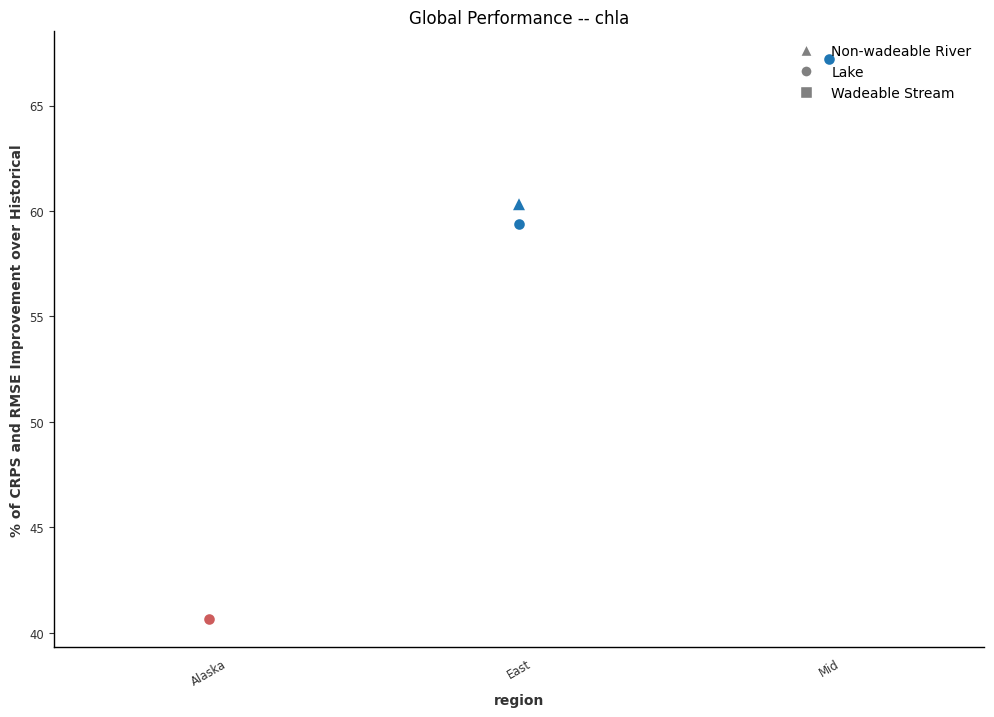

In [19]:
for target_variable in target_variables:
    plot_region_percentages(global_dfs[target_variable], metadata, f'Global Performance -- {target_variable}')

Now looking at the models on site by site basis. DO first.

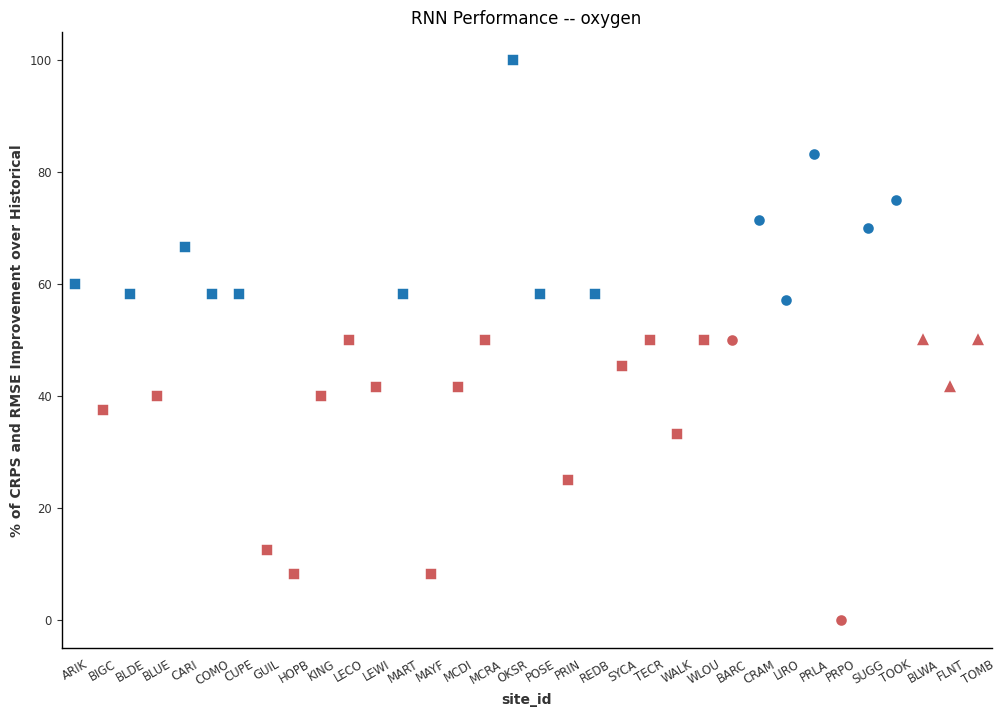

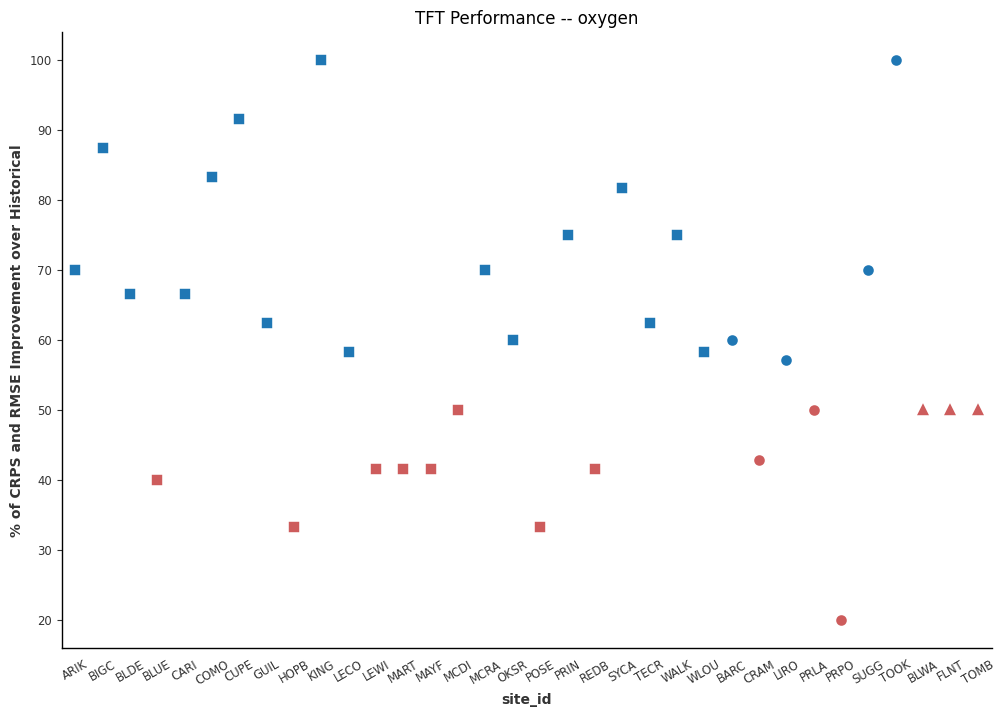

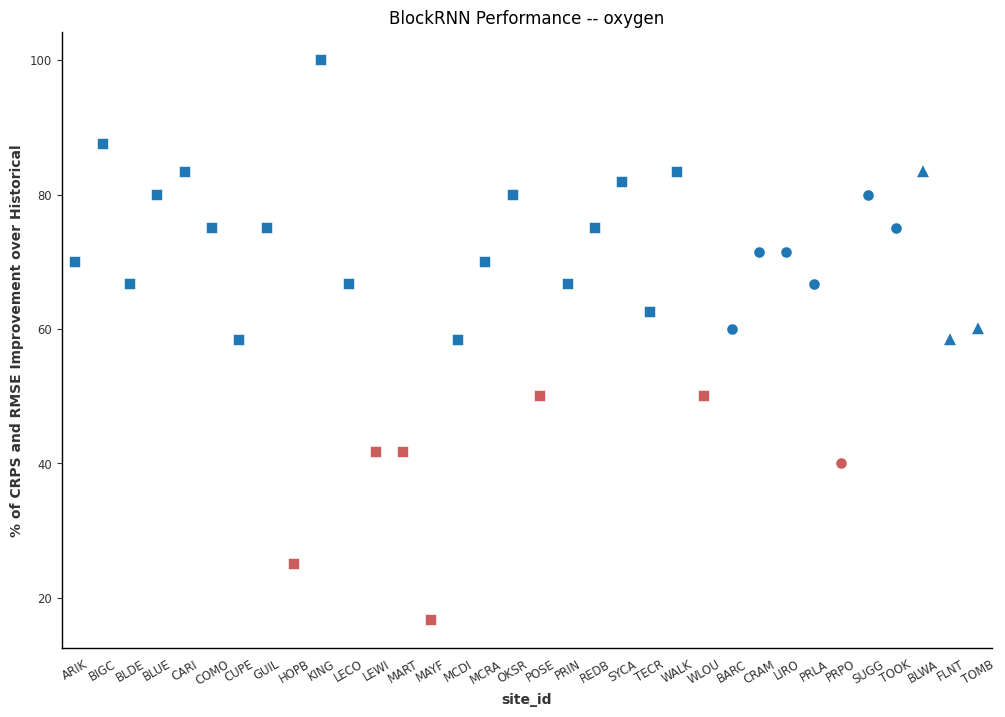

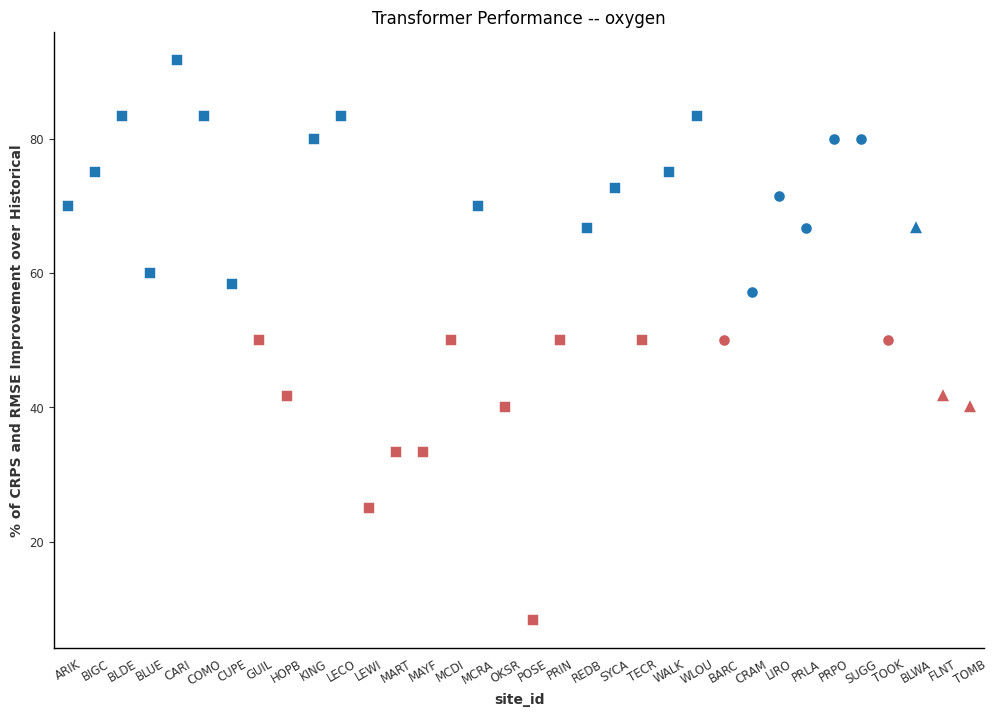

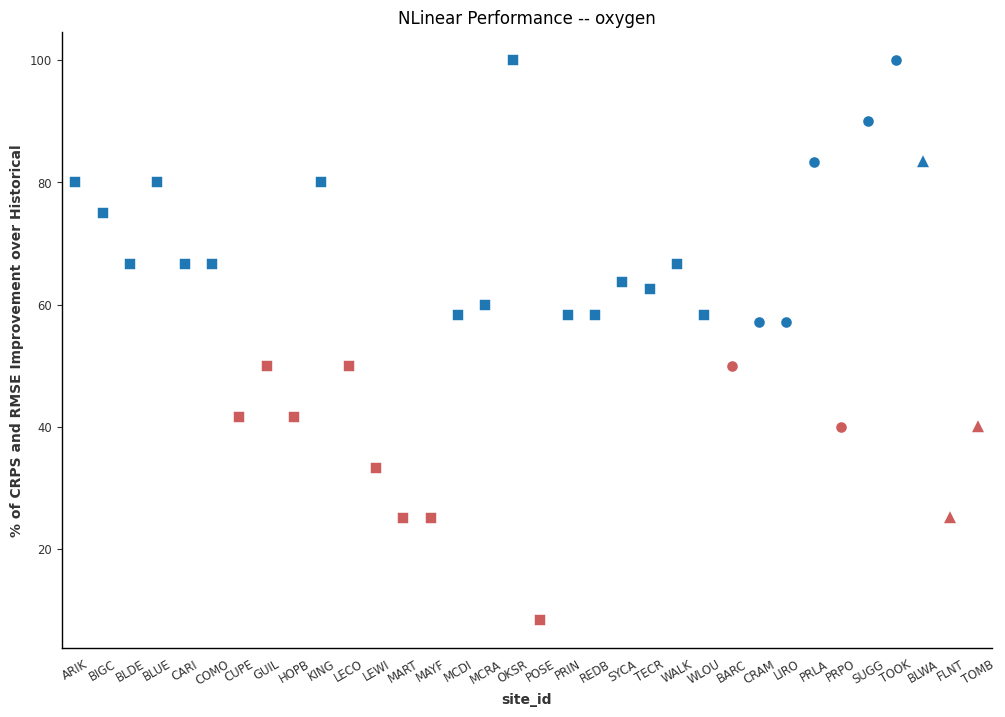

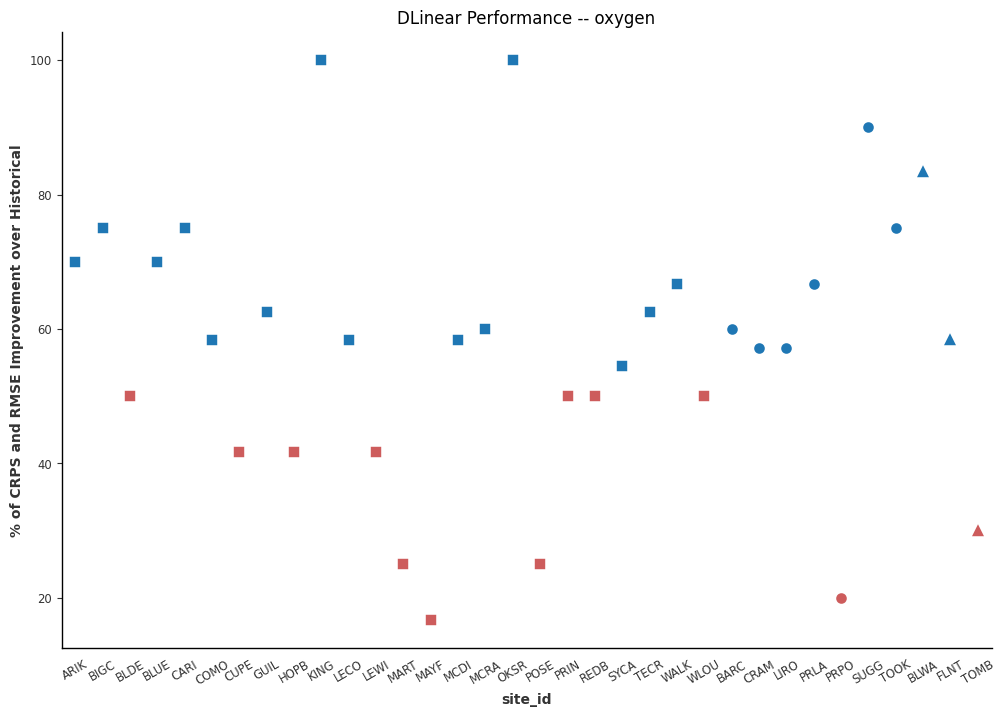

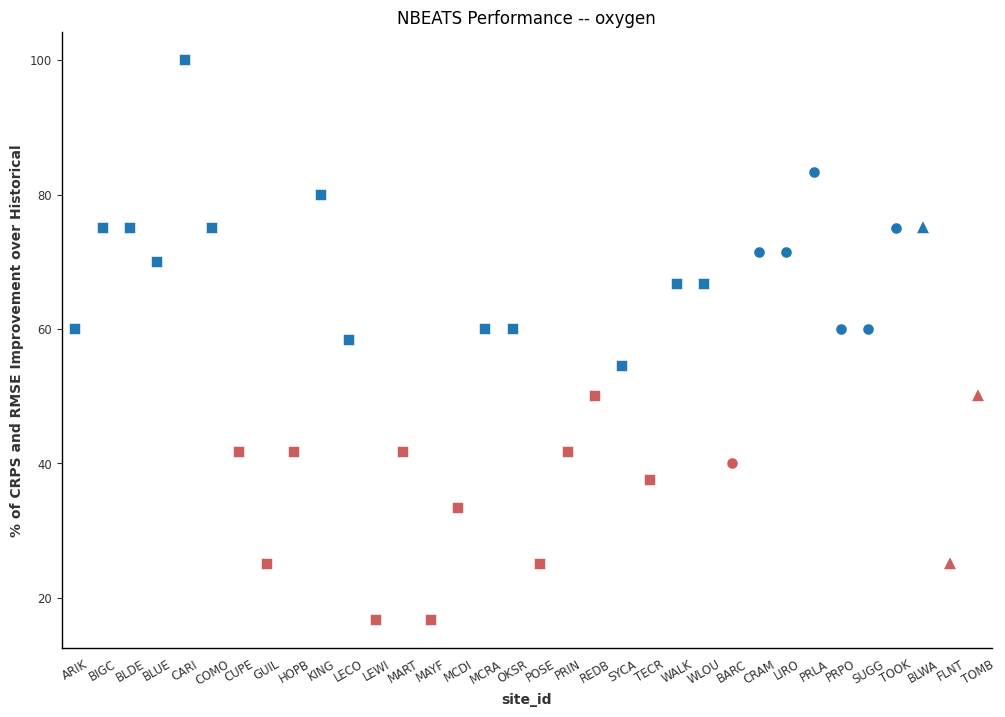

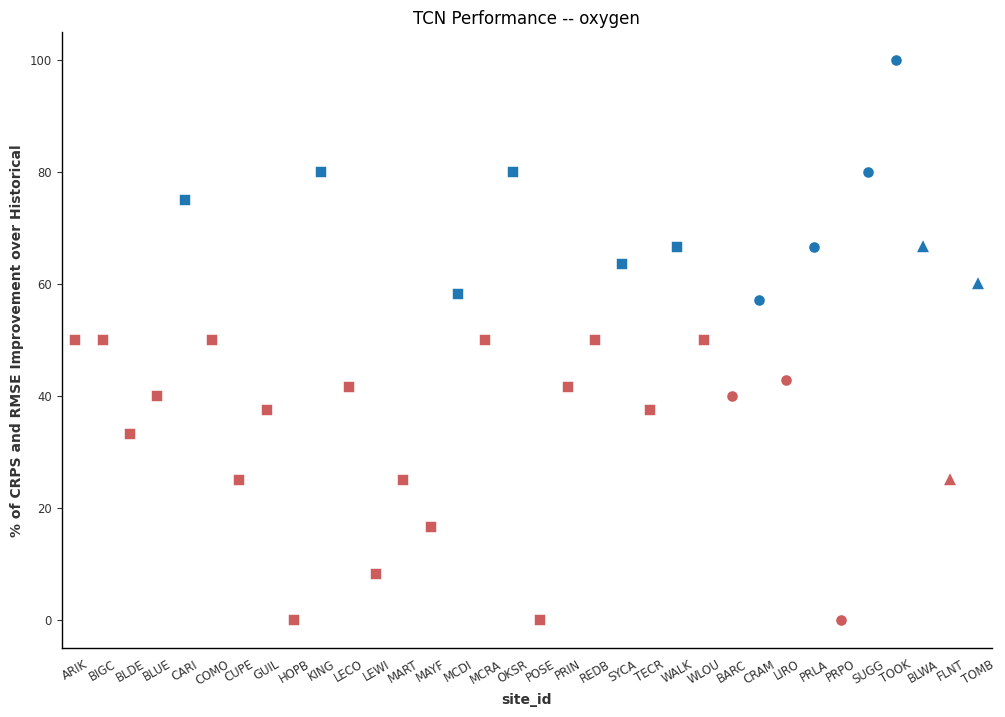

In [29]:
for model in model_names:
    plot_improvement_bysite(scores_dict[model]['oxygen'], metadata, f'{model} Performance -- oxygen')

And, water temperature.

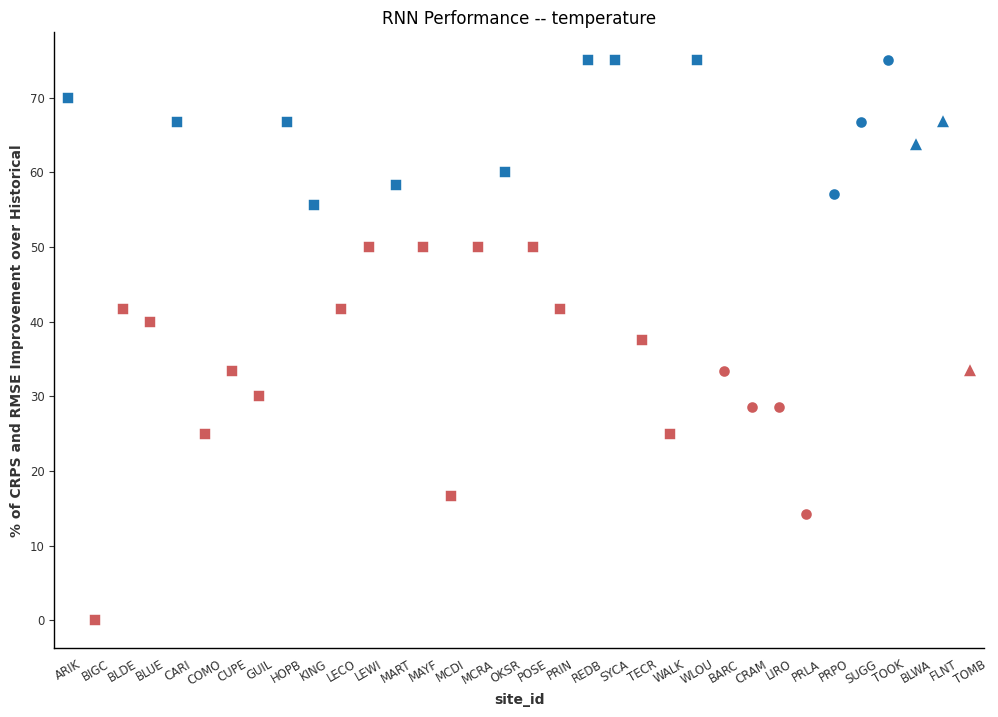

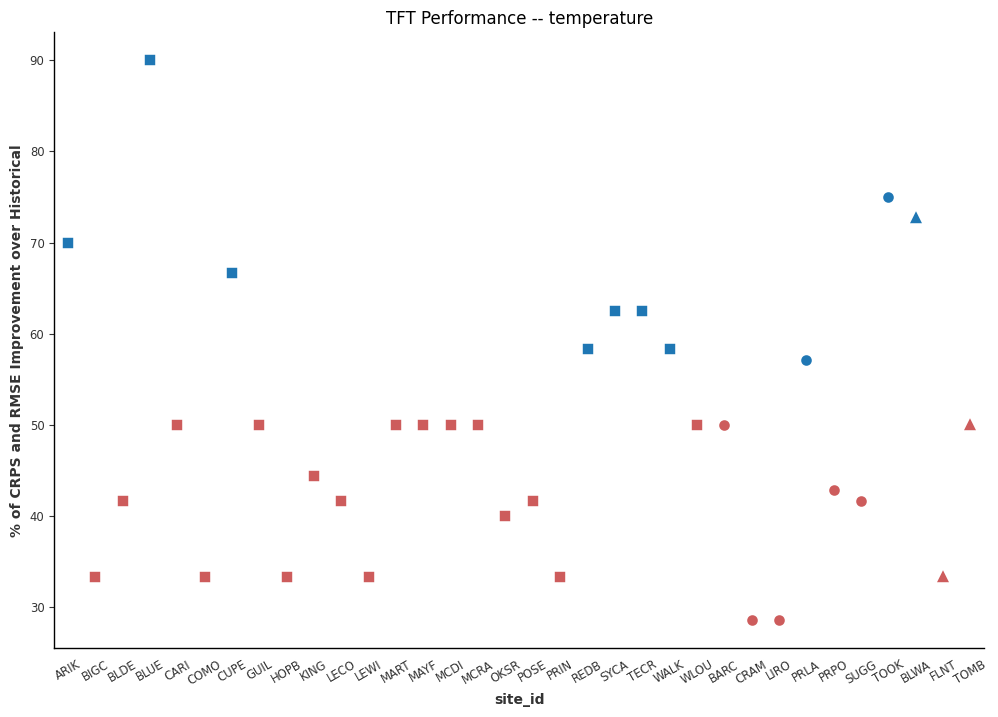

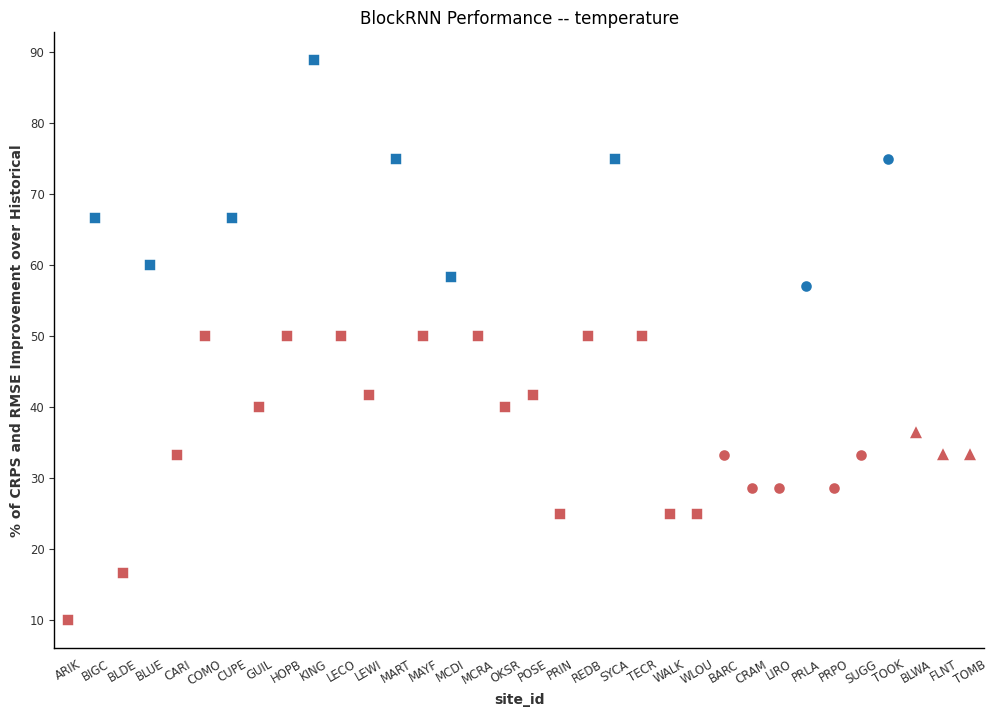

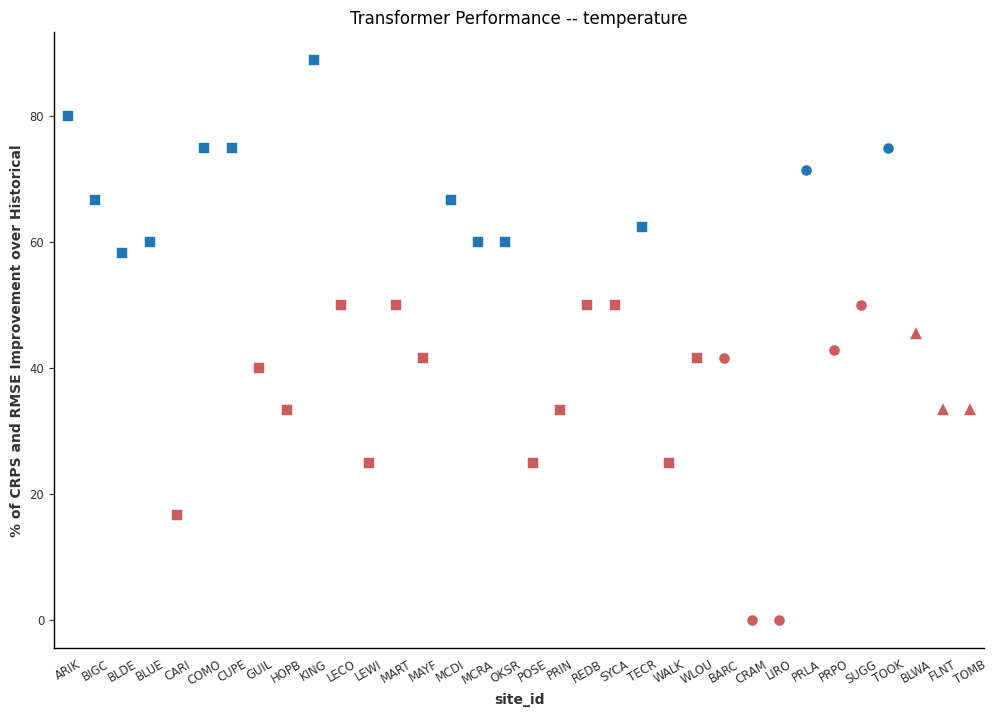

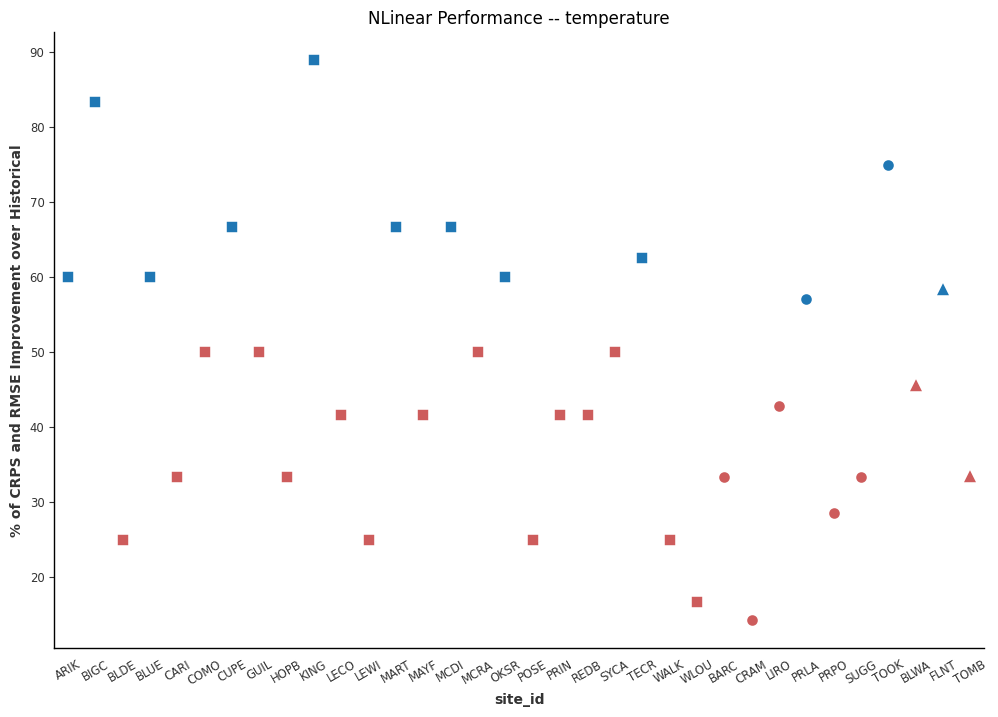

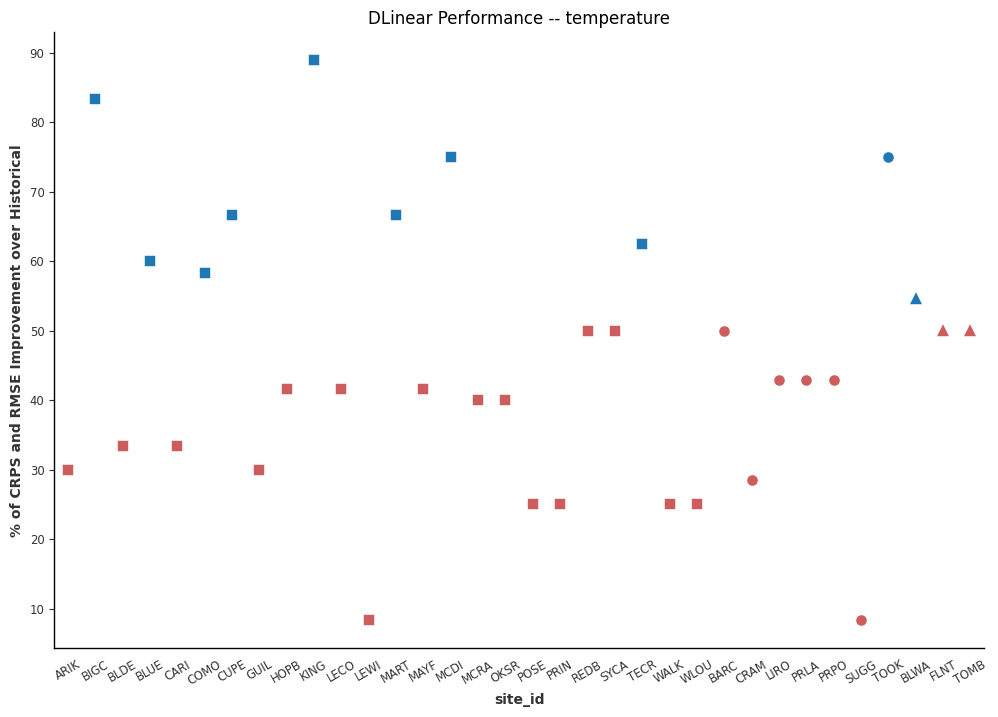

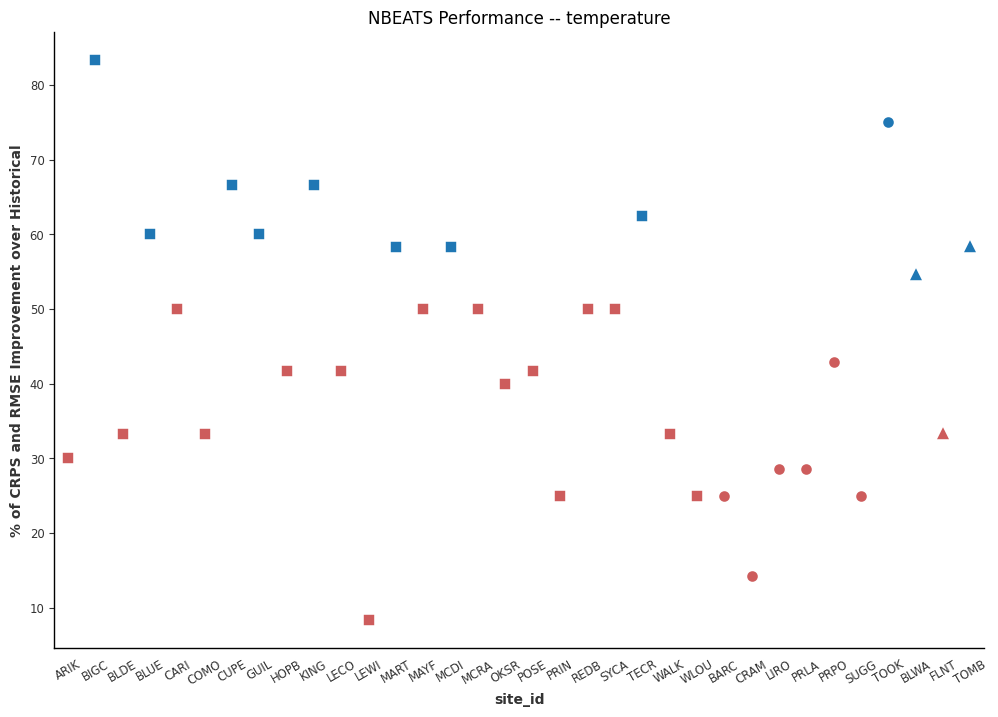

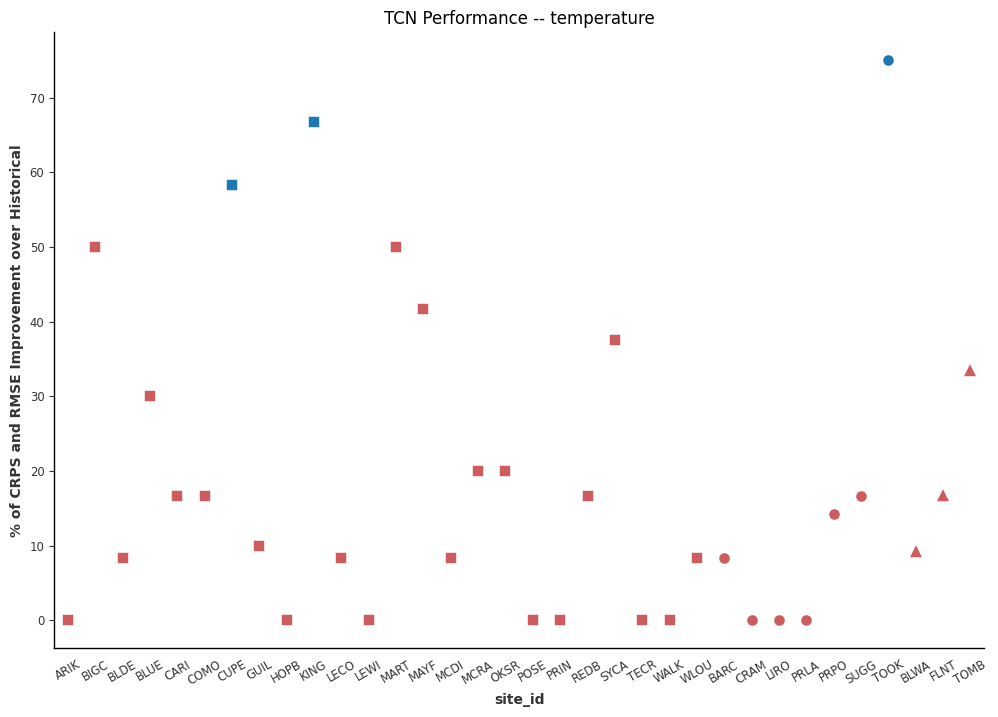

In [30]:
for model in model_names:
    plot_improvement_bysite(scores_dict[model]['temperature'], metadata, f'{model} Performance -- temperature')

And, finally chloryphyll-A

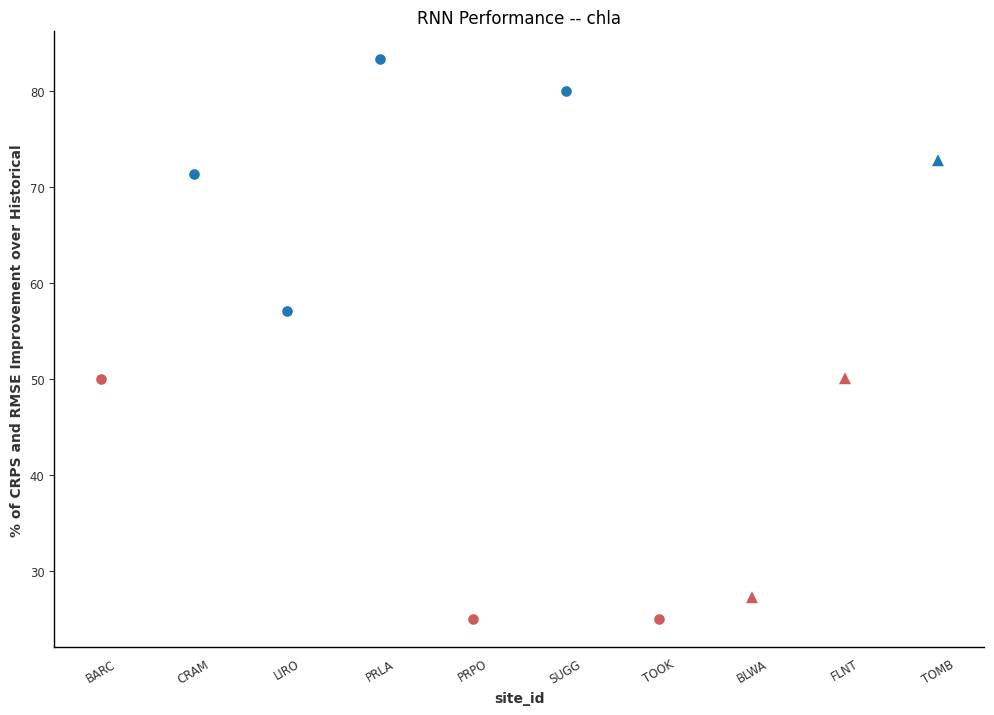

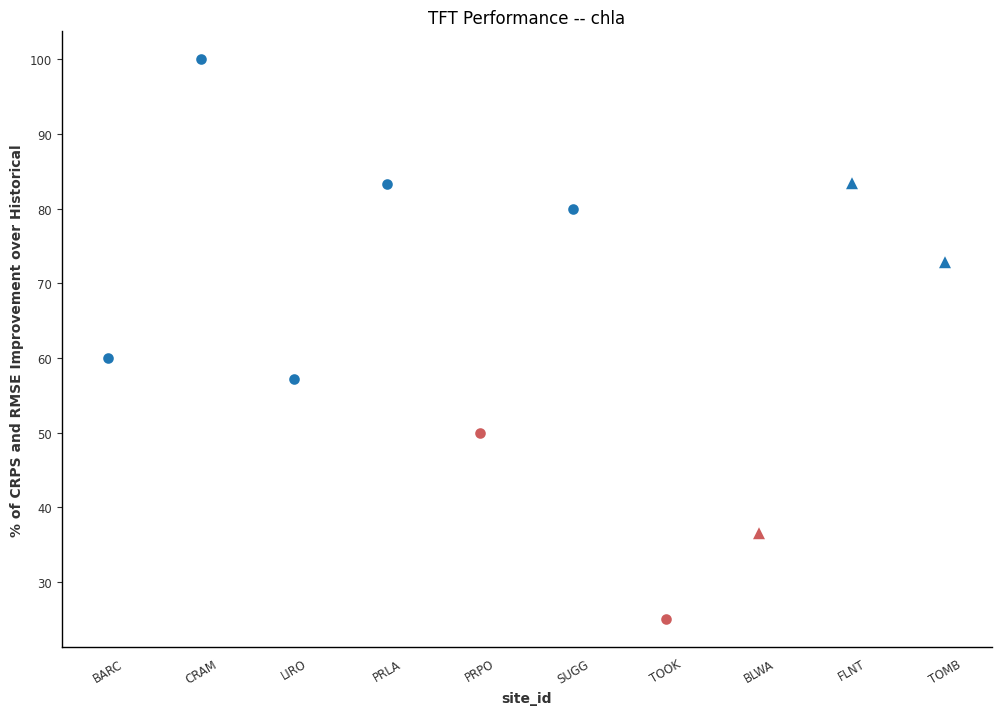

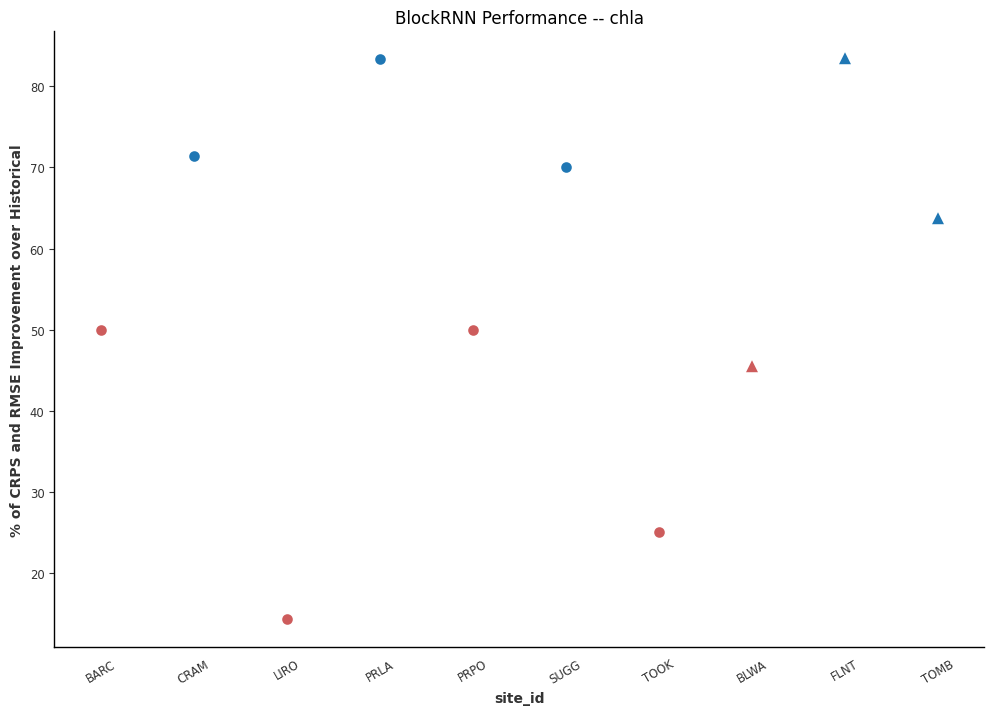

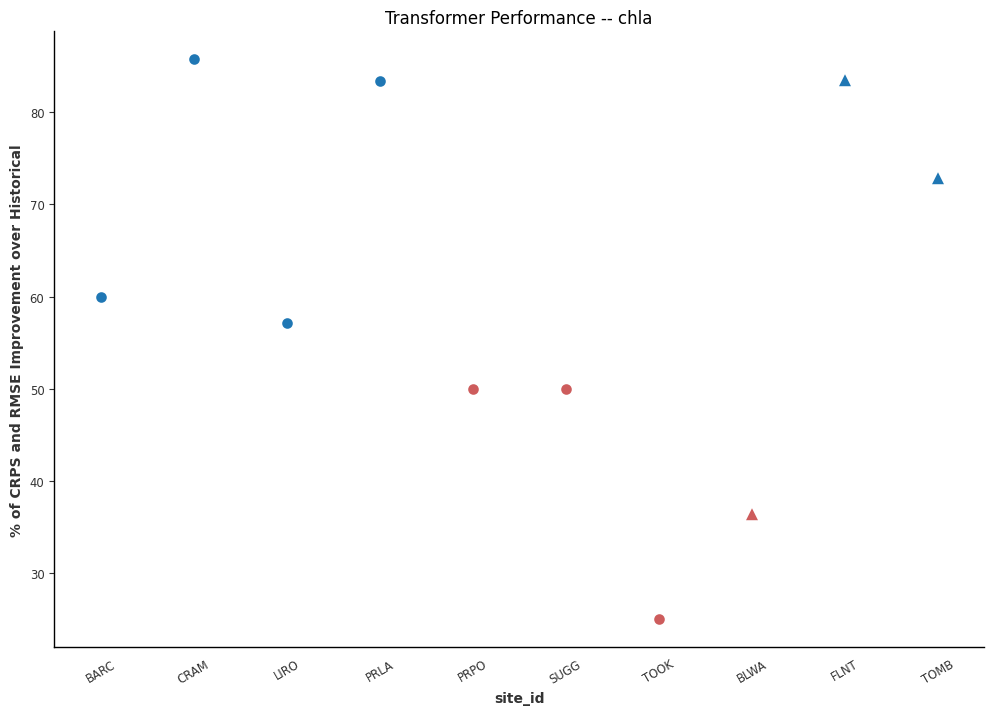

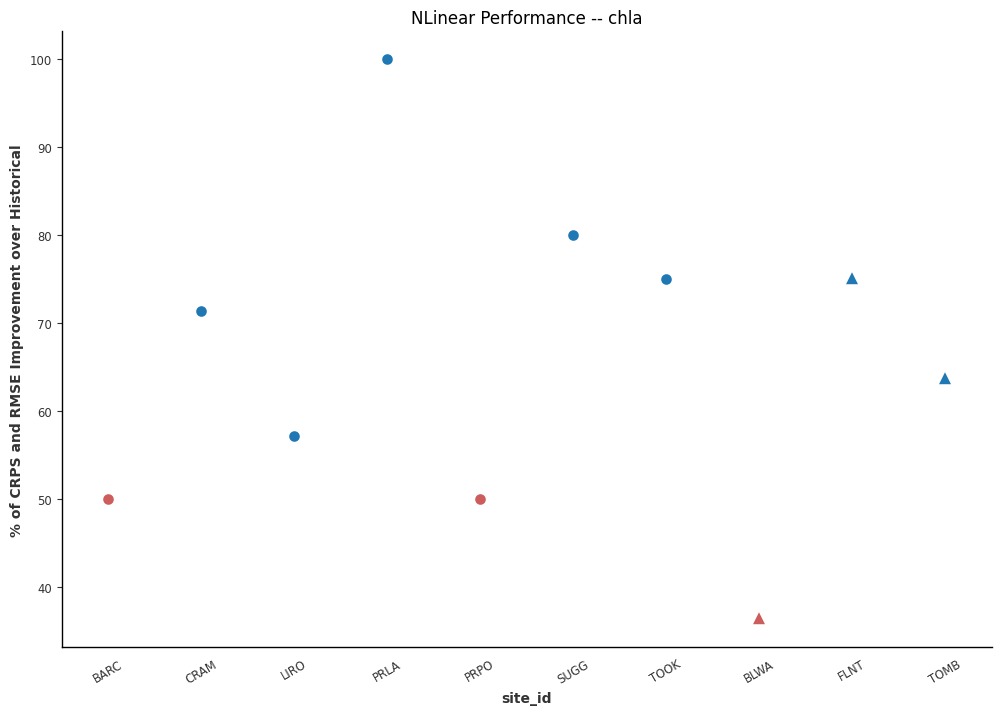

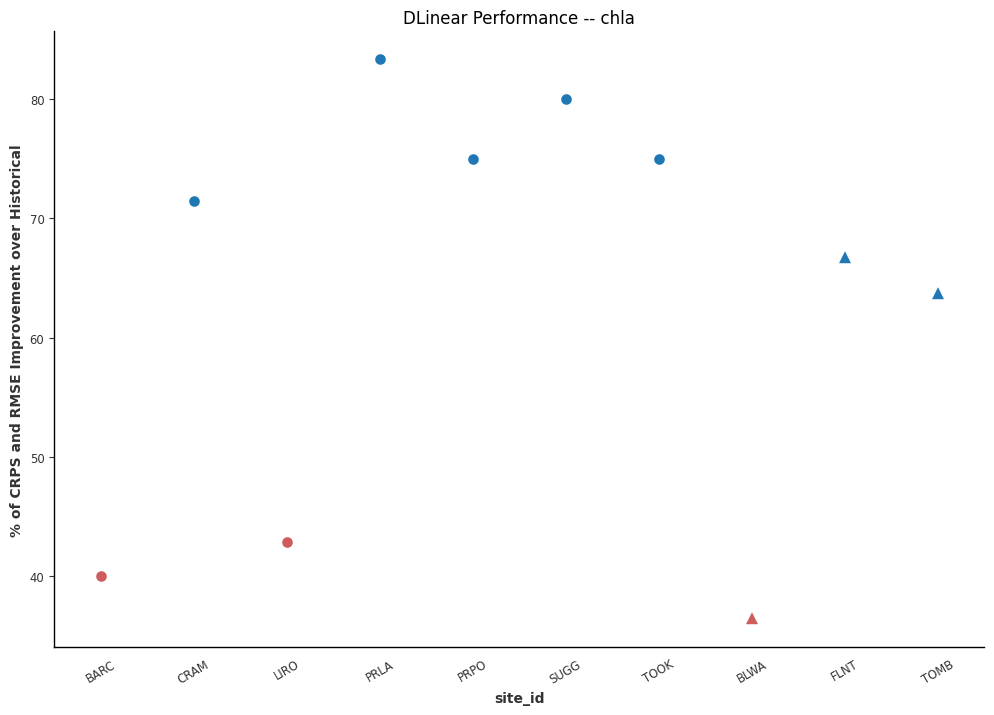

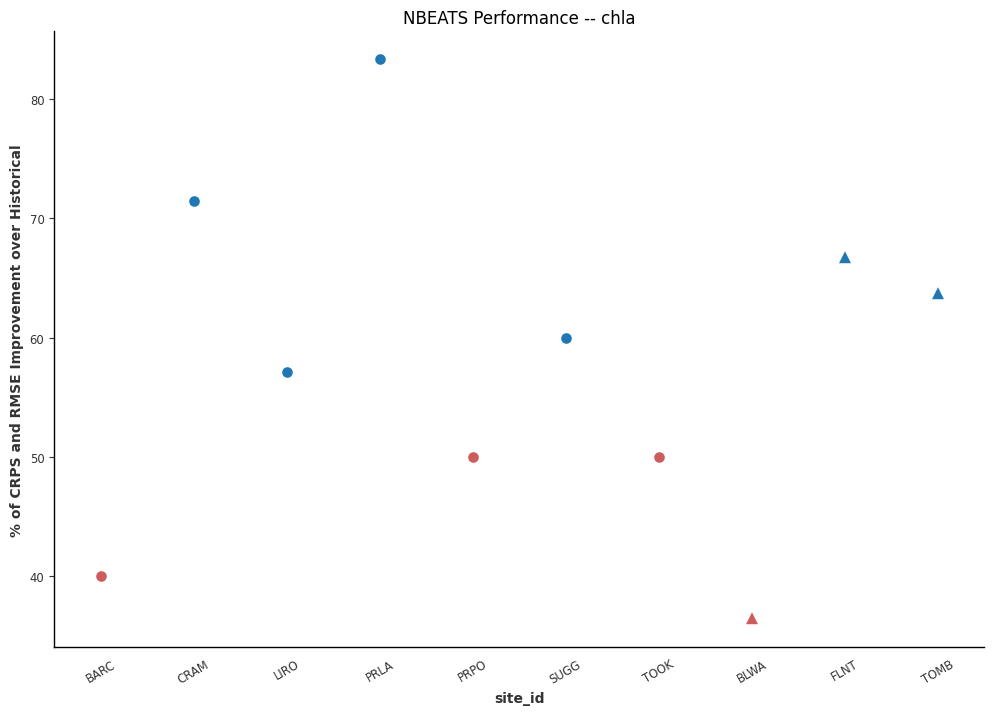

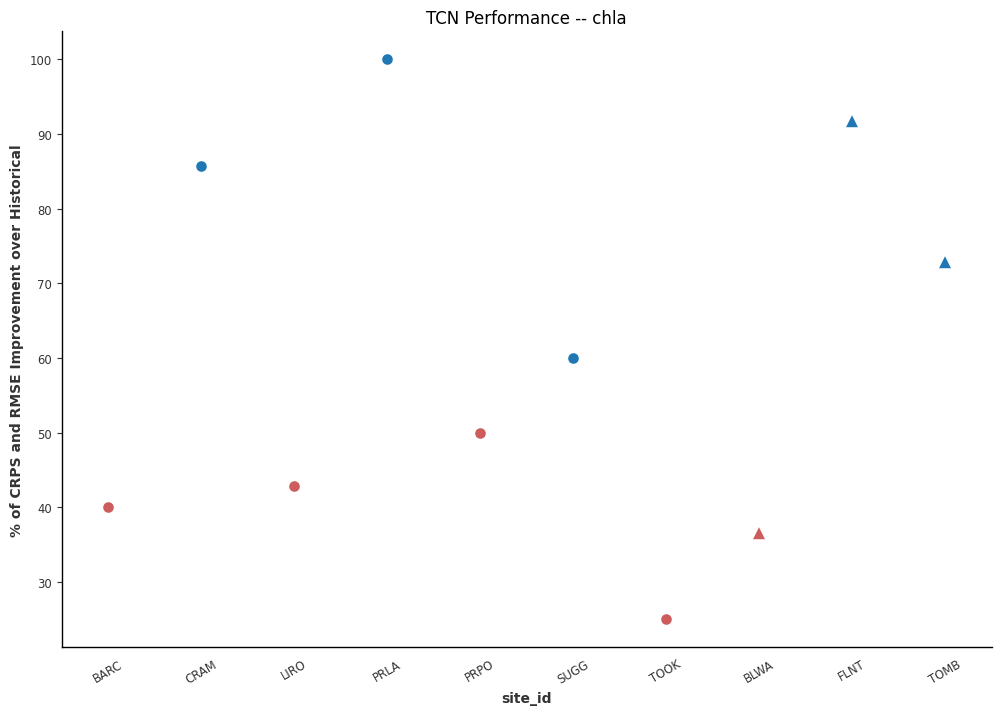

In [31]:
for model in model_names:
    plot_improvement_bysite(scores_dict[model]['chla'], metadata, f'{model} Performance -- chla')

In [27]:
def plot_improvement_bysite(score_df, metadata_df, title_name):
    ## Find the percentage of forecast windows during which the ML model excelled 
    ## the historical forecaster
    score_df = score_df[['site_id', 'combined_improvement']].groupby(['site_id']).mean() * 100
    score_df.reset_index(inplace=True)
    ## Rename the 'combined_improvement' column to 'combined_improvement_percentage'
    score_df.rename(columns={'combined_improvement': 'combined_improvement_percentage'}, inplace=True)

    ## Marking the sites at which 
    score_df['above_50'] = score_df['combined_improvement_percentage'] > 50

    # Combining df's to include metadata
    df = pd.merge(
        score_df, 
        metadata_df, 
        right_on='field_site_id', 
        left_on='site_id'
    ).drop(columns=['field_site_id'])
    
    plt.figure(figsize=(12, 8))
    custom_palette = {True: 'tab:blue', False: 'indianred'}
    markers = {'Wadeable Stream': 's', 'Lake': 'o', 'Non-wadeable River': '^'}

    for site_type in ['Wadeable Stream', 'Lake', 'Non-wadeable River']:
        
        sns.pointplot(
            data=df.loc[df.field_site_subtype == site_type],
            x='site_id',
            y='combined_improvement_percentage',
            linestyle='',
            hue='above_50',
            palette=custom_palette,
            markers=markers[site_type],
        )

    plt.grid(False)
    plt.ylabel("% of CRPS and RMSE Improvement over Historical")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    plt.legend(labels=[])
    plt.title(title_name)

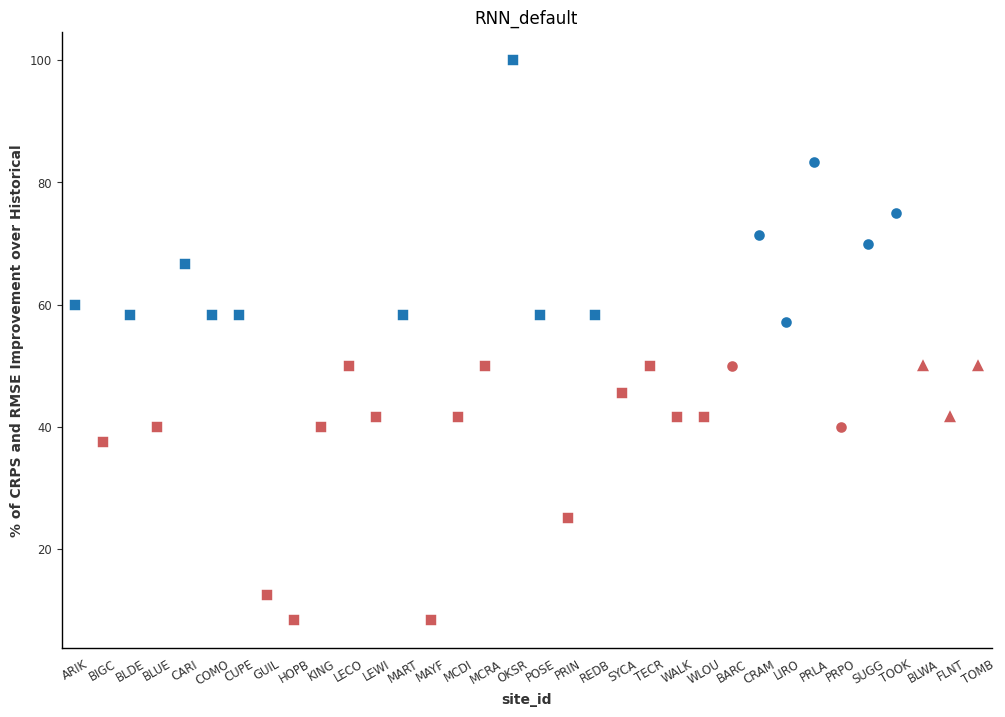

In [91]:
plot_improvement_bysite(rnn_df, metadata, 'RNN_default')

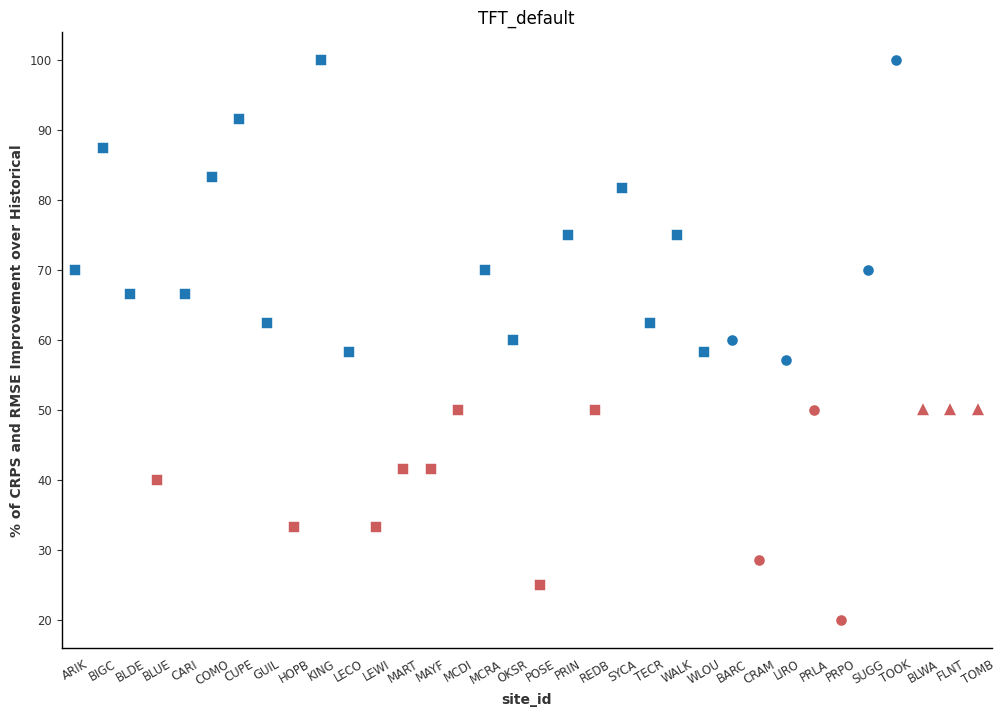

In [92]:
plot_improvement_bysite(tft_df, metadata, 'TFT_default')

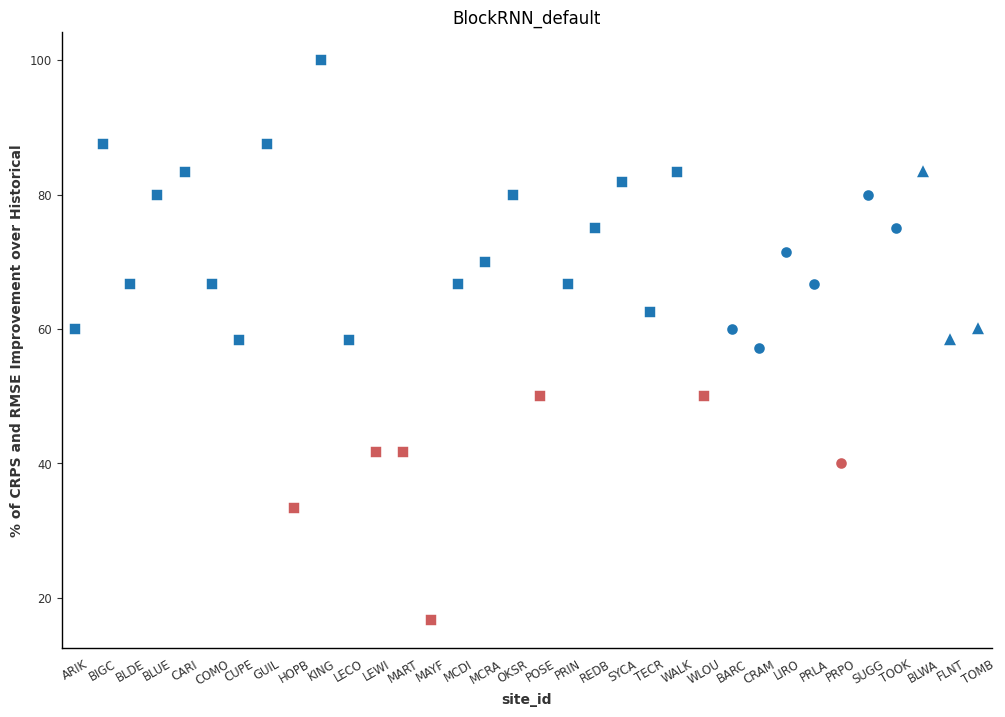

In [93]:
plot_improvement_bysite(blockrnn_df, metadata, 'BlockRNN_default')

Decided to change score_improvement_bysite to return a df that I can use with other plotting functions

In [83]:
import glob
from plotting_utils import (
    modify_score_dict,
    make_df_from_score_dict
)

def score_improvement_bysite(model, targets_df, target_variable, suffix="", plot_name=None):
    score_dict = {}
    # For each site, score CRPS and RMSE individually and add to score_dict
    for site_id in targets_df.site_id.unique():
        site_dict = {}
        glob_prefix = f'forecasts/{site_id}/{target_variable}/{model}_{suffix}/forecast*'
        csv_list = sorted(glob.glob(glob_prefix))
        for csv in csv_list:
            site_dict = modify_score_dict(
                csv, 
                targets_df, 
                target_variable, 
                site_id, 
                suffix, 
                site_dict
            )
            site_dict = modify_score_dict(
                csv, 
                targets_df, 
                target_variable, 
                site_id, 
                suffix, 
                site_dict,
                score_rmse=True,
            )
        score_dict[site_id] = site_dict
    df = make_df_from_score_dict(score_dict)

    df = df.groupby(['site_id', 'date', 'metric', 'model']).mean().reset_index()

    # Filtering
    forecast_df = df[df['model'] == 'forecast']
    historical_df = df[df['model'] == 'historical']

    # Merge the two DataFrames on site_id, date, and metric
    merged_df = pd.merge(
        forecast_df, 
        historical_df, 
        on=['site_id', 'date', 'metric'], 
        suffixes=('_forecast', '_historical')
    )

    # Calculate percent improvement for each metric
    merged_df['percent_improvement'] = ((merged_df['value_historical'] - merged_df['value_forecast']) / merged_df['value_historical']) * 100

    # Finding the amount of windows where the mean crps or rmse has a positive improvement
    merged_df['positive_improvement'] = merged_df['percent_improvement'] > 0

    # Pivoting the table so that we can easily count forecast windows where both rmse and crps
    # had a positive improvement
    pivot_df = merged_df.pivot_table(
        index=['site_id', 'date'], 
        columns='metric', 
        values='positive_improvement'
    )
    pivot_df.columns = ['{}_positive_improvement'.format(col) for col in pivot_df.columns]
    pivot_df.reset_index(inplace=True)

    # Count times where both RMSE and CRPS % improvement were positive
    pivot_df['combined_improvement'] = (
        (pivot_df['crps_positive_improvement'] + pivot_df['rmse_positive_improvement']) == 2
    )

    pivot_df['model'] = model
    return pivot_df

In [84]:
blockrnn_df = score_improvement_bysite('BlockRNN', targets, 'oxygen', suffix='default')

In [86]:
tft_df = score_improvement_bysite('TFT', targets, 'oxygen', suffix='default')

In [87]:
rnn_df = score_improvement_bysite('RNN', targets, 'oxygen', suffix='default')

Make a plot of model types x global percentages

In [187]:
global_dfs

{'oxygen':    site_id  combined_improvement_percentage  above_50
 0     ARIK                        60.000000      True
 1     BARC                        50.000000     False
 2     BIGC                        37.500000     False
 3     BLDE                        58.333333      True
 4     BLUE                        40.000000     False
 ..     ...                              ...       ...
 29    TECR                        37.500000     False
 30    TOMB                        70.000000      True
 31    TOOK                       100.000000      True
 32    WALK                        66.666667      True
 33    WLOU                        50.000000     False
 
 [272 rows x 3 columns]}

In [9]:
def plot_global_percentages(df_, title_name):
    plt.figure(figsize=(12, 8))
    custom_palette = {True: 'tab:blue', False: 'indianred'}
    
    global_percentages = df_[['model', 'combined_improvement']].groupby(['model']).mean() * 100
    global_percentages.reset_index(inplace=True)
    global_percentages.rename(
        columns={'combined_improvement': 'combined_improvement_percentage'}, 
        inplace=True
    )

    # Marking the sites at which 
    global_percentages['above_50'] = global_percentages['combined_improvement_percentage'] > 50
    sns.pointplot(
        data=global_percentages,
        x='model',
        y='combined_improvement_percentage',
        linestyle='',
        hue='above_50',
        palette=custom_palette,
    )

    plt.grid(False)
    plt.ylabel("% of CRPS and RMSE Improvement over Historical")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    plt.legend(labels=[])
    plt.title(title_name)

In [94]:
blockrnn_df.head()

,site_id,date,crps_positive_improvement,rmse_positive_improvement,combined_improvement,model
0,ARIK,2022_09_18,0.0,0.0,False,BlockRNN
1,ARIK,2022_10_18,0.0,0.0,False,BlockRNN
2,ARIK,2022_11_17,1.0,1.0,True,BlockRNN
3,ARIK,2022_12_17,1.0,1.0,True,BlockRNN
4,ARIK,2023_01_16,1.0,1.0,True,BlockRNN


In [97]:
metadata.head()

,field_site_id,field_site_subtype,field_latitude,field_longitude
1,ARIK,Wadeable Stream,39.758206,-102.447150
2,BARC,Lake,29.675982,-82.008414
5,BIGC,Wadeable Stream,37.059719,-119.257550
7,BLDE,Wadeable Stream,44.950110,-110.587150
8,BLUE,Wadeable Stream,34.444218,-96.624201


In [11]:
def plot_site_type_percentages_global(df_, metadata_df, title_name):
    plt.figure(figsize=(12, 8))
    custom_palette = {True: 'tab:blue', False: 'indianred'}

    # Combining df's to include metadata
    df = pd.merge(
        df_, 
        metadata_df, 
        right_on='field_site_id', 
        left_on='site_id'
    ).drop(columns=['field_site_id'])
    
    results = df[['combined_improvement', 'field_site_subtype']].groupby(['field_site_subtype']).mean() * 100
    results.reset_index(inplace=True)
    results.rename(
        columns={'combined_improvement': 'combined_improvement_percentage'}, 
        inplace=True
    )

    # Marking the sites at which 
    results['above_50'] = results['combined_improvement_percentage'] > 50
    sns.pointplot(
        data=results,
        x='field_site_subtype',
        y='combined_improvement_percentage',
        linestyle='',
        hue='above_50',
        palette=custom_palette,
    )

    plt.grid(False)
    plt.ylabel("% of CRPS and RMSE Improvement over Historical")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    plt.legend(labels=[])
    plt.title(title_name)

In [12]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
def plot_site_type_percentages_bymodel(df_, metadata_df, title_name):
    plt.figure(figsize=(12, 8))
    custom_palette = {True: 'tab:blue', False: 'indianred'}
    markers = {'Wadeable Stream': 's', 'Lake': 'o', 'Non-wadeable River': '^'}

    # Combining df's to include metadata
    df = pd.merge(
        df_, 
        metadata_df, 
        right_on='field_site_id', 
        left_on='site_id'
    ).drop(columns=['field_site_id'])
    
    results = df[[
        'combined_improvement', 
        'field_site_subtype', 
        'model'
    ]].groupby(['field_site_subtype', 'model']).mean() * 100
    
    results.reset_index(inplace=True)
    results.rename(
        columns={'combined_improvement': 'combined_improvement_percentage'}, 
        inplace=True
    )

    # Marking the sites at which 
    results['above_50'] = results['combined_improvement_percentage'] > 50

    for site_type in ['Wadeable Stream', 'Lake', 'Non-wadeable River']:
        sns.pointplot(
            data=results.loc[results.field_site_subtype == site_type],
            x='model',
            y='combined_improvement_percentage',
            linestyle='',
            hue='above_50',
            palette=custom_palette,
            markers=markers[site_type],
        )

    plt.grid(False)
    plt.ylabel("% of CRPS and RMSE Improvement over Historical")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    plt.title(title_name)
    # Create your custom legend elements
    triangle = Line2D([0], [0], marker='^', color='w', markerfacecolor='grey', markersize=8, label='Non-wadeable River')
    circle = Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=8, label='Lake')
    square = Line2D([0], [0], marker='s', color='w', markerfacecolor='grey', markersize=8, label='Wadeable Stream')
    
    # Create a custom legend
    legend_elements = [triangle, circle, square]
    plt.legend(labels=[])
    ax.legend(handles=legend_elements, loc='upper right')

In [16]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
def plot_window_and_sitetype_performance(model_df, metadata_df, title_name):
    plt.figure(figsize=(12, 8))
    custom_palette = {True: 'tab:blue', False: 'indianred'}
    markers = {'Wadeable Stream': 's', 'Lake': 'o', 'Non-wadeable River': '^'}

    # Combining df's to include metadata
    df = pd.merge(
        model_df, 
        metadata_df, 
        right_on='field_site_id', 
        left_on='site_id'
    ).drop(columns=['field_site_id'])
    
    results = df[[
        'combined_improvement', 
        'field_site_subtype',
        'date'
    ]].groupby(['field_site_subtype', 'date']).mean() * 100
    
    results.reset_index(inplace=True)
    results.rename(
        columns={'combined_improvement': 'combined_improvement_percentage'}, 
        inplace=True
    )

    # Marking the sites at which 
    results['above_50'] = results['combined_improvement_percentage'] > 50

    for site_type in ['Wadeable Stream', 'Lake', 'Non-wadeable River']:
        sns.pointplot(
            data=results.loc[results.field_site_subtype == site_type],
            x='date',
            y='combined_improvement_percentage',
            linestyle='',
            hue='above_50',
            palette=custom_palette,
            markers=markers[site_type],
        )

    plt.grid(False)
    plt.ylabel("% of CRPS and RMSE Improvement over Historical")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    plt.title(title_name)
    # Create your custom legend elements
    triangle = Line2D([0], [0], marker='^', color='w', markerfacecolor='grey', markersize=8, label='Non-wadeable River')
    circle = Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=8, label='Lake')
    square = Line2D([0], [0], marker='s', color='w', markerfacecolor='grey', markersize=8, label='Wadeable Stream')
    
    # Create a custom legend
    legend_elements = [triangle, circle, square]
    plt.legend(labels=[])
    ax.legend(handles=legend_elements, loc='upper right')
    


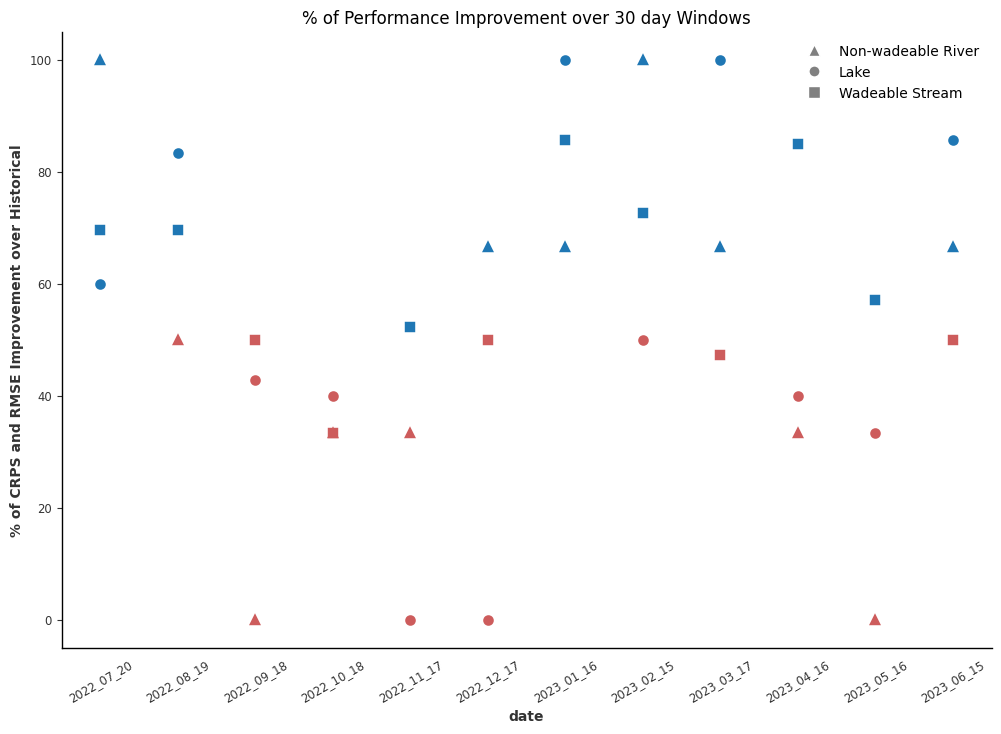

In [120]:
plot_window_and_sitetype_performance(tft_df, metadata, '% of Performance Improvement over 30 day Windows')

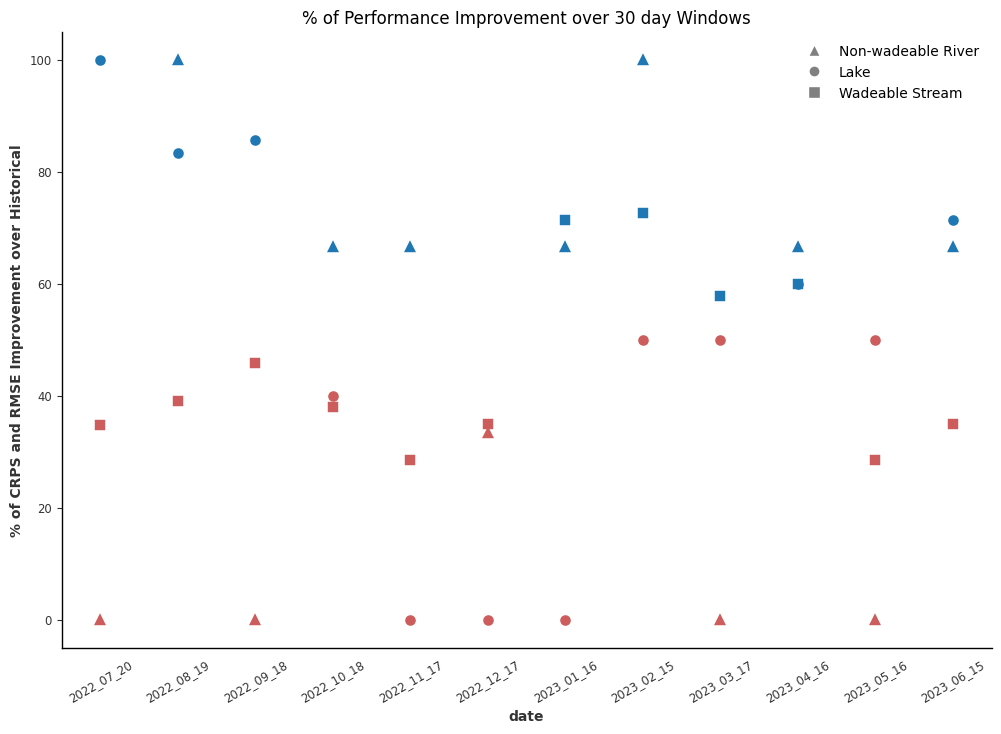

In [121]:
plot_window_and_sitetype_performance(rnn_df, metadata, '% of Performance Improvement over 30 day Windows')

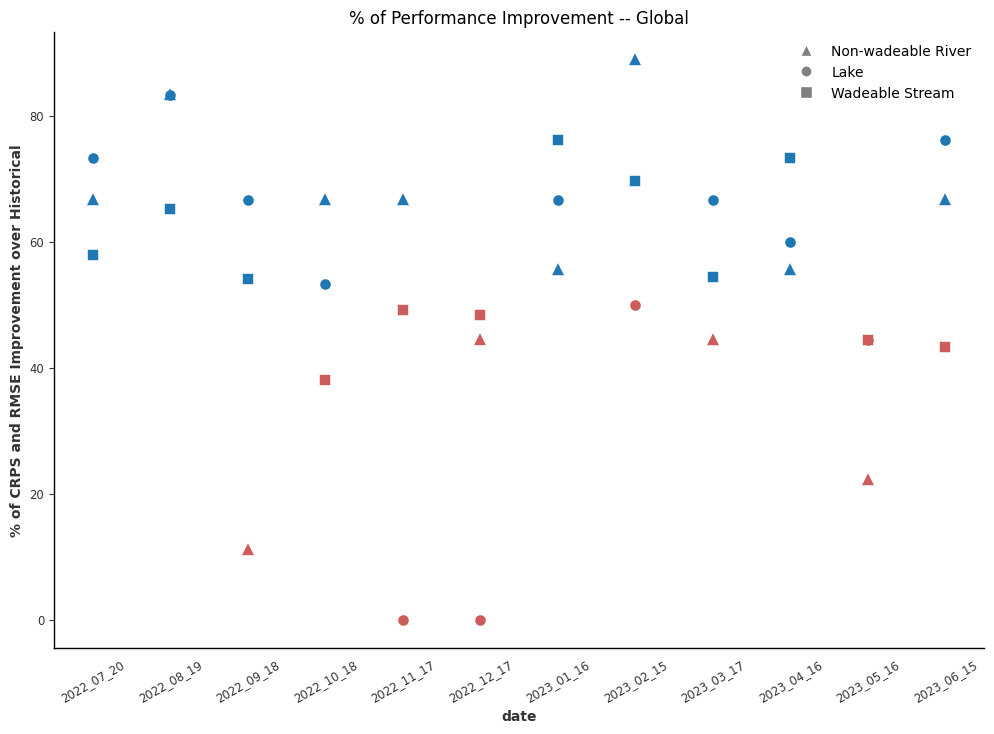

In [124]:
plot_window_and_sitetype_performance(df, metadata, '% of Performance Improvement -- Global')

Latitude, longitudinal considerations?

In [128]:
from copy import copy
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
x = copy(metadata)

/home/rstudio/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


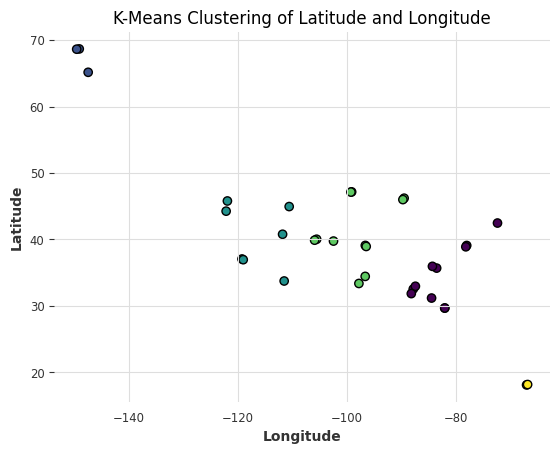

In [142]:
# Define the number of clusters
num_clusters = 5

# Perform K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
x['cluster'] = kmeans.fit_predict(x[['field_latitude', 'field_longitude']])

# Plot the clusters
plt.scatter(x['field_longitude'], x['field_latitude'], c=x['cluster'], cmap='viridis', edgecolors='k')
plt.title('K-Means Clustering of Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

/home/rstudio/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/rstudio/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/rstudio/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/rstudio/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/rstudio/.local/lib/pyt

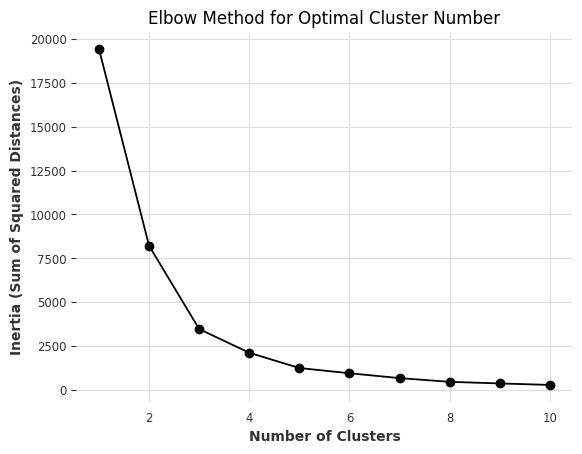

In [131]:

# Evaluate different numbers of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(x[['field_latitude', 'field_longitude']])
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.show()

In [18]:
def plot_region_percentages(df_, metadata_df, title_name):
    plt.figure(figsize=(12, 8))
    custom_palette = {True: 'tab:blue', False: 'indianred'}
    markers = {'Wadeable Stream': 's', 'Lake': 'o', 'Non-wadeable River': '^'}

    # Combining df's to include metadata
    df = pd.merge(
        df_, 
        metadata_df, 
        right_on='field_site_id', 
        left_on='site_id'
    ).drop(columns=['field_site_id'])
    
    results = df[[
        'combined_improvement', 
        'region',
        'field_site_subtype'
    ]].groupby(['field_site_subtype', 'region']).mean() * 100
    
    results.reset_index(inplace=True)
    results.rename(
        columns={'combined_improvement': 'combined_improvement_percentage'}, 
        inplace=True
    )

    # Marking the sites at which 
    results['above_50'] = results['combined_improvement_percentage'] > 50

    for site_type in ['Wadeable Stream', 'Lake', 'Non-wadeable River']:
        sns.pointplot(
            data=results.loc[results.field_site_subtype == site_type],
            x='region',
            y='combined_improvement_percentage',
            linestyle='',
            hue='above_50',
            palette=custom_palette,
            markers=markers[site_type],
        )

    plt.grid(False)
    plt.ylabel("% of CRPS and RMSE Improvement over Historical")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    plt.title(title_name)
    # Create your custom legend elements
    triangle = Line2D([0], [0], marker='^', color='w', markerfacecolor='grey', markersize=8, label='Non-wadeable River')
    circle = Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=8, label='Lake')
    square = Line2D([0], [0], marker='s', color='w', markerfacecolor='grey', markersize=8, label='Wadeable Stream')
    
    # Create a custom legend
    legend_elements = [triangle, circle, square]
    plt.legend(labels=[])
    ax.legend(handles=legend_elements, loc='upper right')

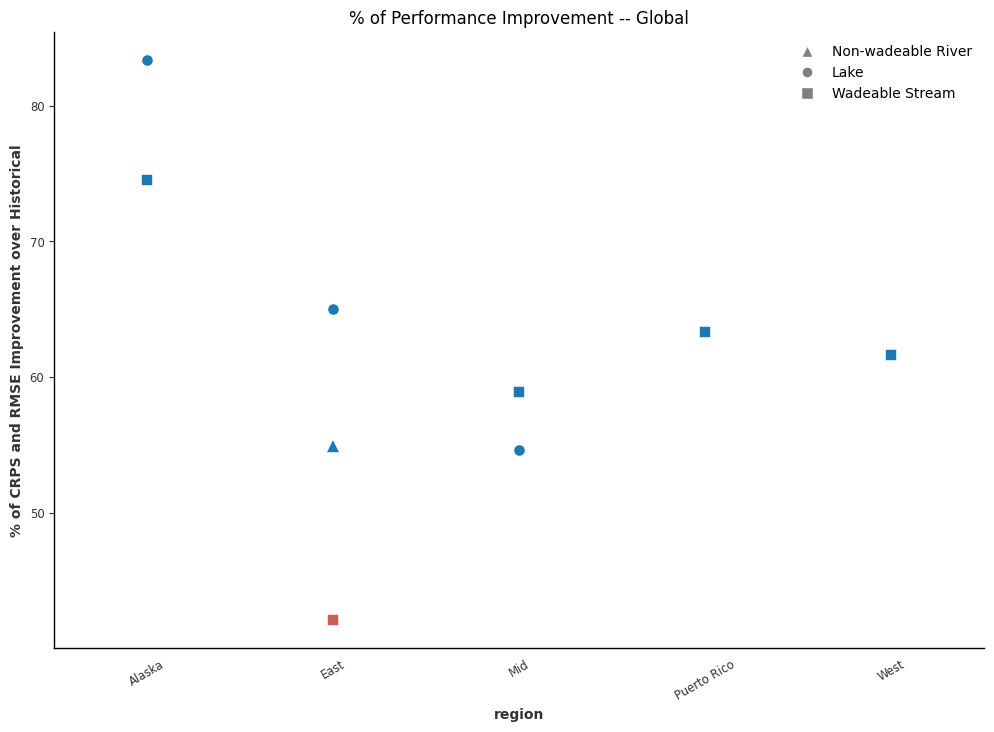

In [148]:
plot_region_percentages(df, metadata, '% of Performance Improvement -- Global')

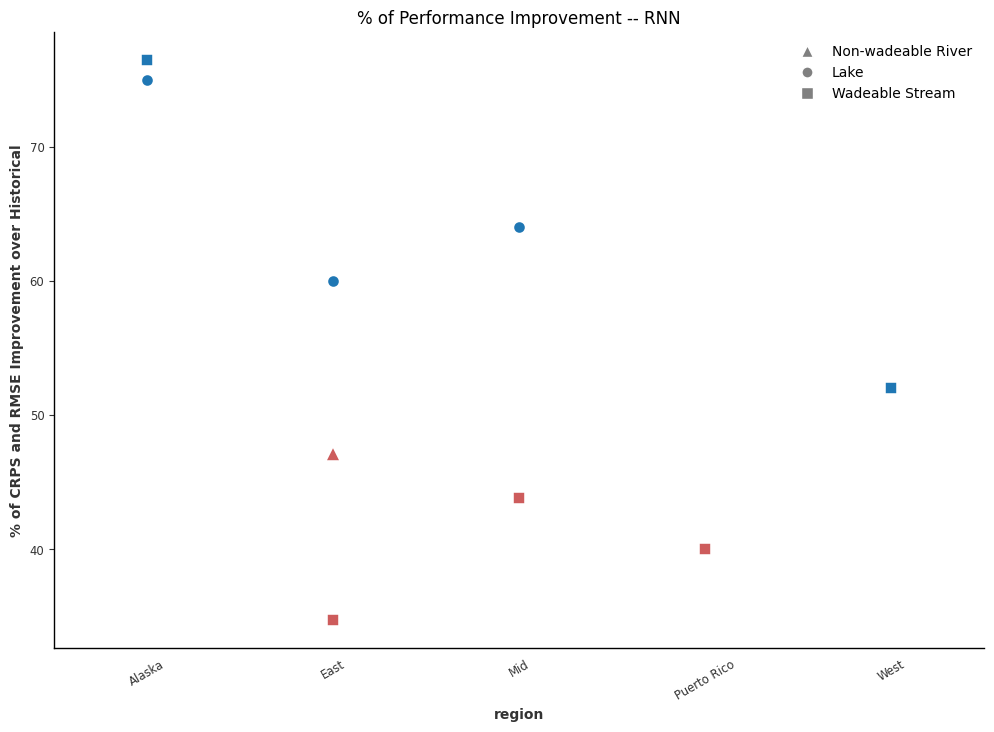

In [151]:
plot_region_percentages(rnn_df, metadata, '% of Performance Improvement -- RNN')

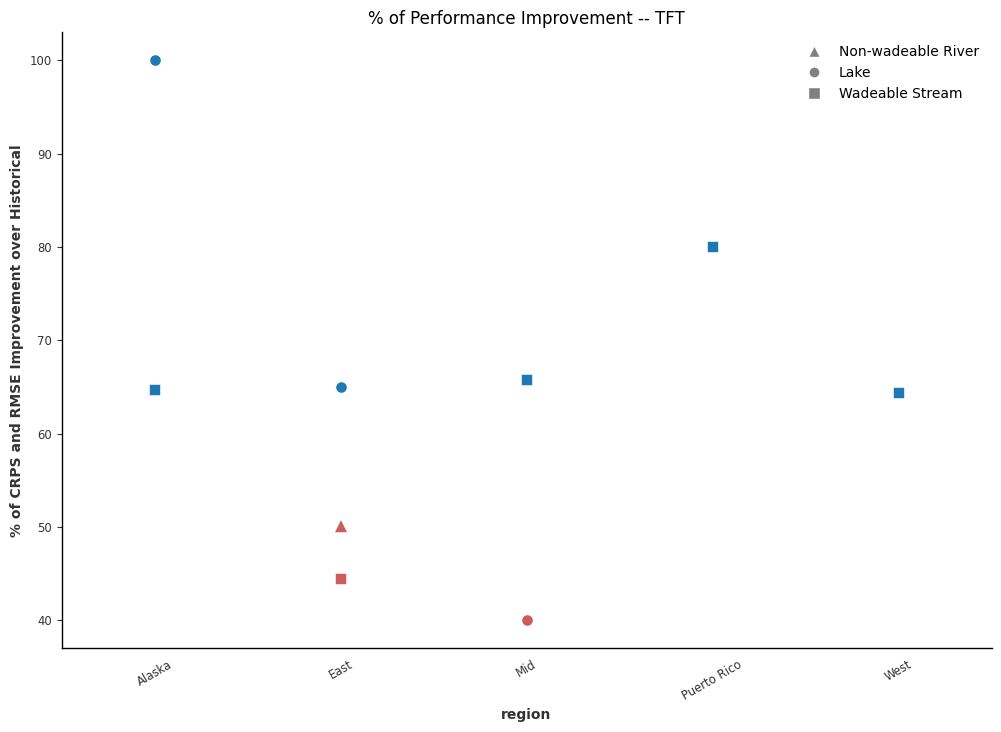

In [152]:
plot_region_percentages(tft_df, metadata, '% of Performance Improvement -- TFT')

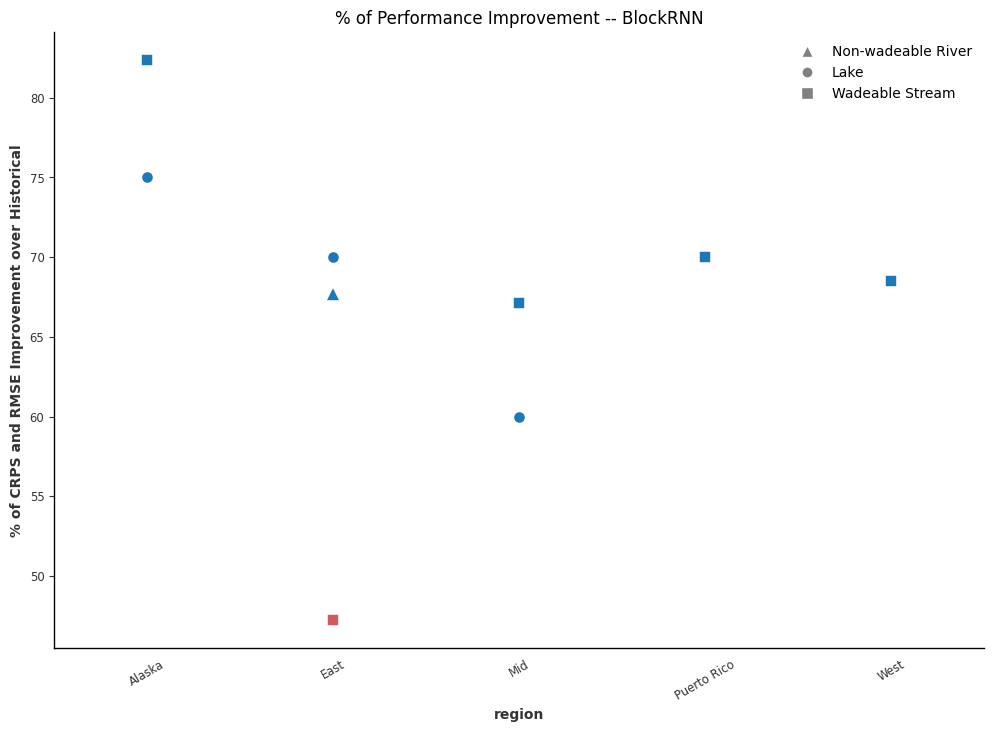

In [154]:
plot_region_percentages(blockrnn_df, metadata, '% of Performance Improvement -- BlockRNN')